Upload the basic notebook

In [12]:
%%capture
%run foundation_notebook.ipynb

In [13]:
print("Notebook run successfully!")

Notebook run successfully!


# 5. Binary classifier - architecture

We build a simple binary classifier, which distinguish between ULDM of spin-0 (L) and pure noise.

Upload the Tensorflow library

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, Input, BatchNormalization, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
np.random.seed(42)

Upload the suggested binary architecture (function)

In [15]:
import importlib
import binary_classifier_function  # Import the module first

importlib.reload(binary_classifier_function)  # Reload the module
from binary_classifier_function import BinaryClassifier

# 6. Training data generation

### A. White noise, no NP

In [83]:
# size of datasets
size = 3000

# mass interval - we focused on a subset of the whole range
mmin = 1e-22 * u.eV
mmax = 1e-21 * u.eV

1. run - data

In [16]:
# S = 25
data_s0l_25_r1_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 0)
# snr = 0
data_s0l_0_r1_A  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "white", nuis_control = 0)

Scalar

In [17]:
combined_s0l_r1_A = np.concatenate((data_s0l_0_r1_A, data_s0l_25_r1_A))

scalar_s0l_A = MinMaxScaler()

combined_s0l_r1_A_normalized = scalar_s0l_A.fit_transform(combined_s0l_r1_A)

In [20]:
import pickle

# Save the scalar
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_A.pkl', 'wb') as f:
    pickle.dump(scalar_s0l_A, f)

Data 1 - normalized

In [38]:
norm_data_s0l_0_r1_A  = scalar_s0l_A.transform(data_s0l_0_r1_A)
norm_data_s0l_25_r1_A = scalar_s0l_A.transform(data_s0l_25_r1_A)

X_s0l_r1_A = np.concatenate((norm_data_s0l_0_r1_A, norm_data_s0l_25_r1_A))

y_0_s0l_r1_A = np.zeros(size)
y_1_s0l_r1_A = np.ones(size)
y_s0l_r1_A = np.concatenate((y_0_s0l_r1_A, y_1_s0l_r1_A)).reshape(-1,1)

# shuffle
indices_r1_A = np.random.permutation(X_s0l_r1_A.shape[0])
X_s0l_r1_A_shuffle = X_s0l_r1_A[indices_r1_A]
y_s0l_r1_A_shuffle = y_s0l_r1_A[indices_r1_A]

# split
split_r1_A = int( 0.8 * len(X_s0l_r1_A_shuffle) )
X_s0l_r1_A_train = X_s0l_r1_A_shuffle[:split_r1_A]
y_s0l_r1_A_train = y_s0l_r1_A_shuffle[:split_r1_A]
X_s0l_r1_A_val   = X_s0l_r1_A_shuffle[split_r1_A:]
y_s0l_r1_A_val   = y_s0l_r1_A_shuffle[split_r1_A:]

In [46]:
del data_s0l_0_r1_A, data_s0l_25_r1_A, norm_data_s0l_0_r1_A, norm_data_s0l_25_r1_A, X_s0l_r1_A, y_0_s0l_r1_A, y_1_s0l_r1_A, y_s0l_r1_A, indices_r1_A, X_s0l_r1_A_shuffle, y_s0l_r1_A_shuffle

2. run - data

In [24]:
# S = 25
data_s0l_25_r2_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 22
data_s0l_22_r2_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 0
data_s0l_0_r2_A  = Nruns_noisydata_SNR_fixed(N = 2 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 0)

Data 2 - normalized

In [40]:
norm_data_s0l_25_r2_A = scalar_s0l_A.transform(data_s0l_25_r2_A)
norm_data_s0l_22_r2_A = scalar_s0l_A.transform(data_s0l_22_r2_A)
norm_data_s0l_0_r2_A  = scalar_s0l_A.transform(data_s0l_0_r2_A)

X_s0l_r2_A = np.concatenate((norm_data_s0l_0_r2_A, norm_data_s0l_22_r2_A, norm_data_s0l_25_r2_A))

y_0_s0l_r2_A  = np.zeros(2*size)
y_1_s0l_r2_A  = np.ones(2*size)
y_s0l_r2_A    = np.concatenate((y_0_s0l_r2_A, y_1_s0l_r2_A)).reshape(-1,1)

# shuffle
indices_r2_A = np.random.permutation(X_s0l_r2_A.shape[0])
X_s0l_r2_A_shuffle = X_s0l_r2_A[indices_r2_A]
y_s0l_r2_A_shuffle = y_s0l_r2_A[indices_r2_A]

# split
split_r2_A = int( 0.8 * len(X_s0l_r2_A_shuffle) )
X_s0l_r2_A_train = X_s0l_r2_A_shuffle[:split_r2_A]
y_s0l_r2_A_train = y_s0l_r2_A_shuffle[:split_r2_A]
X_s0l_r2_A_val   = X_s0l_r2_A_shuffle[split_r2_A:]
y_s0l_r2_A_val   = y_s0l_r2_A_shuffle[split_r2_A:]

In [52]:
del data_s0l_0_r2_A, data_s0l_25_r2_A, norm_data_s0l_0_r2_A, norm_data_s0l_25_r2_A, X_s0l_r2_A, y_0_s0l_r2_A, y_1_s0l_r2_A, y_s0l_r2_A, indices_r2_A, X_s0l_r2_A_shuffle, y_s0l_r2_A_shuffle

3. run - data

In [28]:
# snr = 25
data_s0l_25_r3_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 0)
# snr = 22
data_s0l_22_r3_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 0)
# snr = 19
data_s0l_19_r3_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "white", nuis_control = 0)
# snr = 0
data_s0l_0_r3_A  = Nruns_noisydata_SNR_fixed(N = 3 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 0)

Data 3 - normalized

In [42]:
norm_data_s0l_25_r3_A = scalar_s0l_A.transform(data_s0l_25_r3_A)
norm_data_s0l_22_r3_A = scalar_s0l_A.transform(data_s0l_22_r3_A)
norm_data_s0l_19_r3_A = scalar_s0l_A.transform(data_s0l_19_r3_A)
norm_data_s0l_0_r3_A  = scalar_s0l_A.transform(data_s0l_0_r3_A)

X_s0l_r3_A = np.concatenate((norm_data_s0l_0_r3_A, norm_data_s0l_19_r3_A, norm_data_s0l_22_r3_A, norm_data_s0l_25_r3_A))

y_0_s0l_r3_A  = np.zeros(3*size)
y_1_s0l_r3_A  = np.ones(3*size)
y_s0l_r3_A    = np.concatenate((y_0_s0l_r3_A, y_1_s0l_r3_A)).reshape(-1,1)

# shuffle
indices_r3_A = np.random.permutation(X_s0l_r3_A.shape[0])
X_s0l_r3_A_shuffle = X_s0l_r3_A[indices_r3_A]
y_s0l_r3_A_shuffle = y_s0l_r3_A[indices_r3_A]

# split
split_r3_A = int( 0.8 * len(X_s0l_r3_A_shuffle) )
X_s0l_r3_A_train = X_s0l_r3_A_shuffle[:split_r3_A]
y_s0l_r3_A_train = y_s0l_r3_A_shuffle[:split_r3_A]
X_s0l_r3_A_val   = X_s0l_r3_A_shuffle[split_r3_A:]
y_s0l_r3_A_val   = y_s0l_r3_A_shuffle[split_r3_A:]

In [54]:
del data_s0l_0_r3_A, data_s0l_25_r3_A, norm_data_s0l_0_r3_A, norm_data_s0l_25_r3_A, X_s0l_r3_A, y_0_s0l_r3_A, y_1_s0l_r3_A, y_s0l_r3_A, indices_r3_A, X_s0l_r3_A_shuffle, y_s0l_r3_A_shuffle

4. run - data

In [32]:
# S = 25
data_s0l_25_r4_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 22
data_s0l_22_r4_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 19
data_s0l_19_r4_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 16
data_s0l_16_r4_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 16, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 0
data_s0l_0_r4_A  = Nruns_noisydata_SNR_fixed(N = 4 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 0)

Data 4 - normalized

In [44]:
norm_data_s0l_25_r4_A = scalar_s0l_A.transform(data_s0l_25_r4_A)
norm_data_s0l_22_r4_A = scalar_s0l_A.transform(data_s0l_22_r4_A)
norm_data_s0l_19_r4_A = scalar_s0l_A.transform(data_s0l_19_r4_A)
norm_data_s0l_16_r4_A = scalar_s0l_A.transform(data_s0l_16_r4_A)
norm_data_s0l_0_r4_A  = scalar_s0l_A.transform(data_s0l_0_r4_A)

X_s0l_r4_A = np.concatenate((norm_data_s0l_0_r4_A, norm_data_s0l_16_r4_A, norm_data_s0l_19_r4_A, norm_data_s0l_22_r4_A, norm_data_s0l_25_r4_A))

y_0_s0l_r4_A  = np.zeros(4*size)
y_1_s0l_r4_A  = np.ones(4*size)
y_s0l_r4_A = np.concatenate((y_0_s0l_r4_A, y_1_s0l_r4_A)).reshape(-1,1)

# shuffle
indices_r4_A = np.random.permutation(X_s0l_r4_A.shape[0])
X_s0l_r4_A_shuffle = X_s0l_r4_A[indices_r4_A]
y_s0l_r4_A_shuffle = y_s0l_r4_A[indices_r4_A]

# split
split_r4_A = int( 0.8 * len(X_s0l_r4_A_shuffle) )
X_s0l_r4_A_train = X_s0l_r4_A_shuffle[:split_r4_A]
y_s0l_r4_A_train = y_s0l_r4_A_shuffle[:split_r4_A]
X_s0l_r4_A_val   = X_s0l_r4_A_shuffle[split_r4_A:]
y_s0l_r4_A_val   = y_s0l_r4_A_shuffle[split_r4_A:]

In [56]:
del data_s0l_0_r4_A, data_s0l_25_r4_A, norm_data_s0l_0_r4_A, norm_data_s0l_25_r4_A, X_s0l_r4_A, y_0_s0l_r4_A, y_1_s0l_r4_A, y_s0l_r4_A, indices_r4_A, X_s0l_r4_A_shuffle, y_s0l_r4_A_shuffle

5. run - data

In [368]:
# S = 25
data_s0l_25_r5_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 22
data_s0l_22_r5_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 19
data_s0l_19_r5_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 16
data_s0l_16_r5_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 16, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 13
data_s0l_13_r5_A = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 13, spin = "s0l", noise_model = "white", nuis_control = 0)
# S = 0
data_s0l_0_r5_A  = Nruns_noisydata_SNR_fixed(N = 5 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 0)

Data 5 - normalized

In [372]:
norm_data_s0l_25_r5_A = scalar_s0l_A.transform(data_s0l_25_r5_A)
norm_data_s0l_22_r5_A = scalar_s0l_A.transform(data_s0l_22_r5_A)
norm_data_s0l_19_r5_A = scalar_s0l_A.transform(data_s0l_19_r5_A)
norm_data_s0l_16_r5_A = scalar_s0l_A.transform(data_s0l_16_r5_A)
norm_data_s0l_13_r5_A = scalar_s0l_A.transform(data_s0l_13_r5_A)
norm_data_s0l_0_r5_A  = scalar_s0l_A.transform(data_s0l_0_r5_A)

X_s0l_r5_A = np.concatenate((norm_data_s0l_0_r5_A, norm_data_s0l_13_r5_A, norm_data_s0l_16_r5_A, norm_data_s0l_19_r5_A, norm_data_s0l_22_r5_A, norm_data_s0l_25_r5_A))

y_0_s0l_r5_A  = np.zeros(5*size)
y_1_s0l_r5_A  = np.ones(5*size)
y_s0l_r5_A = np.concatenate((y_0_s0l_r5_A, y_1_s0l_r5_A)).reshape(-1,1)

# shuffle
indices_r5_A = np.random.permutation(X_s0l_r5_A.shape[0])
X_s0l_r5_A_shuffle = X_s0l_r5_A[indices_r5_A]
y_s0l_r5_A_shuffle = y_s0l_r5_A[indices_r5_A]

# split
split_r5_A = int( 0.8 * len(X_s0l_r5_A_shuffle) )
X_s0l_r5_A_train = X_s0l_r5_A_shuffle[:split_r5_A]
y_s0l_r5_A_train = y_s0l_r5_A_shuffle[:split_r5_A]
X_s0l_r5_A_val   = X_s0l_r5_A_shuffle[split_r5_A:]
y_s0l_r5_A_val   = y_s0l_r5_A_shuffle[split_r5_A:]

In [465]:
import pickle

# Define your dictionaries as given
Xy_direct_r1_A = { 
    'X_s0l_r1_A_train': X_s0l_r1_A_train, 
    'y_s0l_r1_A_train': y_s0l_r1_A_train, 
    'X_s0l_r1_A_val': X_s0l_r1_A_val, 
    'y_s0l_r1_A_val': y_s0l_r1_A_val 
}

Xy_direct_r2_A = { 
    'X_s0l_r2_A_train': X_s0l_r2_A_train, 
    'y_s0l_r2_A_train': y_s0l_r2_A_train, 
    'X_s0l_r2_A_val': X_s0l_r2_A_val, 
    'y_s0l_r2_A_val': y_s0l_r2_A_val 
}

Xy_direct_r3_A = { 
    'X_s0l_r3_A_train': X_s0l_r3_A_train, 
    'y_s0l_r3_A_train': y_s0l_r3_A_train, 
    'X_s0l_r3_A_val': X_s0l_r3_A_val, 
    'y_s0l_r3_A_val': y_s0l_r3_A_val 
}

Xy_direct_r4_A = { 
    'X_s0l_r4_A_train': X_s0l_r4_A_train, 
    'y_s0l_r4_A_train': y_s0l_r4_A_train, 
    'X_s0l_r4_A_val': X_s0l_r4_A_val, 
    'y_s0l_r4_A_val': y_s0l_r4_A_val 
}

Xy_direct_r5_A = { 
    'X_s0l_r5_A_train': X_s0l_r5_A_train, 
    'y_s0l_r5_A_train': y_s0l_r5_A_train, 
    'X_s0l_r5_A_val': X_s0l_r5_A_val, 
    'y_s0l_r5_A_val': y_s0l_r5_A_val 
}

# Save the dictionaries to a pickle file
with open('store/files/binary_classifier_spin0L_only/Xy_direct_r1_r5_A.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r1_A': Xy_direct_r1_A,
        'Xy_direct_r2_A': Xy_direct_r2_A,
        'Xy_direct_r3_A': Xy_direct_r3_A,
        'Xy_direct_r4_A': Xy_direct_r4_A,
        'Xy_direct_r5_A': Xy_direct_r5_A
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


### B. White noise, NP incl.

1. run - data

In [169]:
# S = 25
data_s0l_25_r1_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 0
data_s0l_0_r1_B  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "white", nuis_control = 1)

Scalar

In [170]:
combined_s0l_r1_B = np.concatenate((data_s0l_0_r1_B, data_s0l_25_r1_B))

scalar_s0l_B = MinMaxScaler()

combined_s0l_r1_B_normalized = scalar_s0l_B.fit_transform(combined_s0l_r1_B)

In [171]:
import pickle

# Save the scalar
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_B.pkl', 'wb') as f:
    pickle.dump(scalar_s0l_B, f)

Data 1 - normalized

In [172]:
norm_data_s0l_0_r1_B  = scalar_s0l_B.transform(data_s0l_0_r1_B)
norm_data_s0l_25_r1_B = scalar_s0l_B.transform(data_s0l_25_r1_B)

X_s0l_r1_B = np.concatenate((norm_data_s0l_0_r1_B, norm_data_s0l_25_r1_B))

y_0_s0l_r1_B = np.zeros(size)
y_1_s0l_r1_B = np.ones(size)
y_s0l_r1_B = np.concatenate((y_0_s0l_r1_B, y_1_s0l_r1_B)).reshape(-1,1)

# shuffle
indices_r1_B = np.random.permutation(X_s0l_r1_B.shape[0])
X_s0l_r1_B_shuffle = X_s0l_r1_B[indices_r1_B]
y_s0l_r1_B_shuffle = y_s0l_r1_B[indices_r1_B]

# split
split_r1_B = int( 0.8 * len(X_s0l_r1_B_shuffle) )
X_s0l_r1_B_train = X_s0l_r1_B_shuffle[:split_r1_B]
y_s0l_r1_B_train = y_s0l_r1_B_shuffle[:split_r1_B]
X_s0l_r1_B_val   = X_s0l_r1_B_shuffle[split_r1_B:]
y_s0l_r1_B_val   = y_s0l_r1_B_shuffle[split_r1_B:]

2. run - data

In [177]:
# S = 25
data_s0l_25_r2_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 22
data_s0l_22_r2_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 0
data_s0l_0_r2_B  = Nruns_noisydata_SNR_fixed(N = 2 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 1)

Data 2 - normalized

In [179]:
norm_data_s0l_25_r2_B = scalar_s0l_B.transform(data_s0l_25_r2_B)
norm_data_s0l_22_r2_B = scalar_s0l_B.transform(data_s0l_22_r2_B)
norm_data_s0l_0_r2_B  = scalar_s0l_B.transform(data_s0l_0_r2_B)

X_s0l_r2_B = np.concatenate((norm_data_s0l_0_r2_B, norm_data_s0l_22_r2_B, norm_data_s0l_25_r2_B))

y_0_s0l_r2_B  = np.zeros(2*size)
y_1_s0l_r2_B  = np.ones(2*size)
y_s0l_r2_B    = np.concatenate((y_0_s0l_r2_B, y_1_s0l_r2_B)).reshape(-1,1)

# shuffle
indices_r2_B = np.random.permutation(X_s0l_r2_B.shape[0])
X_s0l_r2_B_shuffle = X_s0l_r2_B[indices_r2_B]
y_s0l_r2_B_shuffle = y_s0l_r2_B[indices_r2_B]

# split
split_r2_B = int( 0.8 * len(X_s0l_r2_B_shuffle) )
X_s0l_r2_B_train = X_s0l_r2_B_shuffle[:split_r2_B]
y_s0l_r2_B_train = y_s0l_r2_B_shuffle[:split_r2_B]
X_s0l_r2_B_val   = X_s0l_r2_B_shuffle[split_r2_B:]
y_s0l_r2_B_val   = y_s0l_r2_B_shuffle[split_r2_B:]

3. run - data

In [218]:
# snr = 25
data_s0l_25_r3_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 1)
# snr = 22
data_s0l_22_r3_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 1)
# snr = 19
data_s0l_19_r3_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "white", nuis_control = 1)
# snr = 0
data_s0l_0_r3_B  = Nruns_noisydata_SNR_fixed(N = 3 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 1)

Data 3 - normalized

In [219]:
norm_data_s0l_25_r3_B = scalar_s0l_B.transform(data_s0l_25_r3_B)
norm_data_s0l_22_r3_B = scalar_s0l_B.transform(data_s0l_22_r3_B)
norm_data_s0l_19_r3_B = scalar_s0l_B.transform(data_s0l_19_r3_B)
norm_data_s0l_0_r3_B  = scalar_s0l_B.transform(data_s0l_0_r3_B)

X_s0l_r3_B = np.concatenate((norm_data_s0l_0_r3_B, norm_data_s0l_19_r3_B, norm_data_s0l_22_r3_B, norm_data_s0l_25_r3_B))

y_0_s0l_r3_B  = np.zeros(3*size)
y_1_s0l_r3_B  = np.ones(3*size)
y_s0l_r3_B    = np.concatenate((y_0_s0l_r3_B, y_1_s0l_r3_B)).reshape(-1,1)

# shuffle
indices_r3_B = np.random.permutation(X_s0l_r3_B.shape[0])
X_s0l_r3_B_shuffle = X_s0l_r3_B[indices_r3_B]
y_s0l_r3_B_shuffle = y_s0l_r3_B[indices_r3_B]

# split
split_r3_B = int( 0.8 * len(X_s0l_r3_B_shuffle) )
X_s0l_r3_B_train = X_s0l_r3_B_shuffle[:split_r3_B]
y_s0l_r3_B_train = y_s0l_r3_B_shuffle[:split_r3_B]
X_s0l_r3_B_val   = X_s0l_r3_B_shuffle[split_r3_B:]
y_s0l_r3_B_val   = y_s0l_r3_B_shuffle[split_r3_B:]

4. run - data

In [220]:
# S = 25
data_s0l_25_r4_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 22
data_s0l_22_r4_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 19
data_s0l_19_r4_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 16
data_s0l_16_r4_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 16, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 0
data_s0l_0_r4_B  = Nruns_noisydata_SNR_fixed(N = 4 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 1)

Data 4 - normalized

In [221]:
norm_data_s0l_25_r4_B = scalar_s0l_B.transform(data_s0l_25_r4_B)
norm_data_s0l_22_r4_B = scalar_s0l_B.transform(data_s0l_22_r4_B)
norm_data_s0l_19_r4_B = scalar_s0l_B.transform(data_s0l_19_r4_B)
norm_data_s0l_16_r4_B = scalar_s0l_B.transform(data_s0l_16_r4_B)
norm_data_s0l_0_r4_B  = scalar_s0l_B.transform(data_s0l_0_r4_B)

X_s0l_r4_B = np.concatenate((norm_data_s0l_0_r4_B, norm_data_s0l_16_r4_B, norm_data_s0l_19_r4_B, norm_data_s0l_22_r4_B, norm_data_s0l_25_r4_B))

y_0_s0l_r4_B  = np.zeros(4*size)
y_1_s0l_r4_B  = np.ones(4*size)
y_s0l_r4_B = np.concatenate((y_0_s0l_r4_B, y_1_s0l_r4_B)).reshape(-1,1)

# shuffle
indices_r4_B = np.random.permutation(X_s0l_r4_B.shape[0])
X_s0l_r4_B_shuffle = X_s0l_r4_B[indices_r4_B]
y_s0l_r4_B_shuffle = y_s0l_r4_B[indices_r4_B]

# split
split_r4_B = int( 0.8 * len(X_s0l_r4_B_shuffle) )
X_s0l_r4_B_train = X_s0l_r4_B_shuffle[:split_r4_B]
y_s0l_r4_B_train = y_s0l_r4_B_shuffle[:split_r4_B]
X_s0l_r4_B_val   = X_s0l_r4_B_shuffle[split_r4_B:]
y_s0l_r4_B_val   = y_s0l_r4_B_shuffle[split_r4_B:]

In [360]:
del data_s0l_0_r4_B, data_s0l_25_r4_B, norm_data_s0l_0_r4_B, norm_data_s0l_25_r4_B, X_s0l_r4_B, y_0_s0l_r4_B, y_1_s0l_r4_B, y_s0l_r4_B, indices_r4_B, X_s0l_r4_B_shuffle, y_s0l_r4_B_shuffle

5. run - data

In [374]:
# S = 25
data_s0l_25_r5_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 22
data_s0l_22_r5_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 19
data_s0l_19_r5_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 16
data_s0l_16_r5_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 16, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 13
data_s0l_13_r5_B = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 13, spin = "s0l", noise_model = "white", nuis_control = 1)
# S = 0
data_s0l_0_r5_B  = Nruns_noisydata_SNR_fixed(N = 5 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 1)

Data 5 - normalized

In [379]:
norm_data_s0l_25_r5_B = scalar_s0l_B.transform(data_s0l_25_r5_B)
norm_data_s0l_22_r5_B = scalar_s0l_B.transform(data_s0l_22_r5_B)
norm_data_s0l_19_r5_B = scalar_s0l_B.transform(data_s0l_19_r5_B)
norm_data_s0l_16_r5_B = scalar_s0l_B.transform(data_s0l_16_r5_B)
norm_data_s0l_13_r5_B = scalar_s0l_B.transform(data_s0l_13_r5_B)
norm_data_s0l_0_r5_B  = scalar_s0l_B.transform(data_s0l_0_r5_B)

X_s0l_r5_B = np.concatenate((norm_data_s0l_0_r5_B, norm_data_s0l_13_r5_B, norm_data_s0l_16_r5_B, norm_data_s0l_19_r5_B, norm_data_s0l_22_r5_B, norm_data_s0l_25_r5_B))

y_0_s0l_r5_B  = np.zeros(5*size)
y_1_s0l_r5_B  = np.ones(5*size)
y_s0l_r5_B = np.concatenate((y_0_s0l_r5_B, y_1_s0l_r5_B)).reshape(-1,1)

# shuffle
indices_r5_B = np.random.permutation(X_s0l_r5_B.shape[0])
X_s0l_r5_B_shuffle = X_s0l_r5_B[indices_r5_B]
y_s0l_r5_B_shuffle = y_s0l_r5_B[indices_r5_B]

# split
split_r5_B = int( 0.8 * len(X_s0l_r5_B_shuffle) )
X_s0l_r5_B_train = X_s0l_r5_B_shuffle[:split_r5_B]
y_s0l_r5_B_train = y_s0l_r5_B_shuffle[:split_r5_B]
X_s0l_r5_B_val   = X_s0l_r5_B_shuffle[split_r5_B:]
y_s0l_r5_B_val   = y_s0l_r5_B_shuffle[split_r5_B:]

In [467]:
import pickle

# Define your dictionaries as given
Xy_direct_r1_B = { 
    'X_s0l_r1_B_train': X_s0l_r1_B_train, 
    'y_s0l_r1_B_train': y_s0l_r1_B_train, 
    'X_s0l_r1_B_val': X_s0l_r1_B_val, 
    'y_s0l_r1_B_val': y_s0l_r1_B_val 
}

Xy_direct_r2_B = { 
    'X_s0l_r2_B_train': X_s0l_r2_B_train, 
    'y_s0l_r2_B_train': y_s0l_r2_B_train, 
    'X_s0l_r2_B_val': X_s0l_r2_B_val, 
    'y_s0l_r2_B_val': y_s0l_r2_B_val 
}

Xy_direct_r3_B = { 
    'X_s0l_r3_B_train': X_s0l_r3_B_train, 
    'y_s0l_r3_B_train': y_s0l_r3_B_train, 
    'X_s0l_r3_B_val': X_s0l_r3_B_val, 
    'y_s0l_r3_B_val': y_s0l_r3_B_val 
}

Xy_direct_r4_B = { 
    'X_s0l_r4_B_train': X_s0l_r4_B_train, 
    'y_s0l_r4_B_train': y_s0l_r4_B_train, 
    'X_s0l_r4_B_val': X_s0l_r4_B_val, 
    'y_s0l_r4_B_val': y_s0l_r4_B_val 
}

Xy_direct_r5_B = { 
    'X_s0l_r5_B_train': X_s0l_r5_B_train, 
    'y_s0l_r5_B_train': y_s0l_r5_B_train, 
    'X_s0l_r5_B_val': X_s0l_r5_B_val, 
    'y_s0l_r5_B_val': y_s0l_r5_B_val 
}

# Save the dictionaries to a pickle file
with open('store/files/binary_classifier_spin0L_only/Xy_direct_r1_r5_B.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r1_B': Xy_direct_r1_B,
        'Xy_direct_r2_B': Xy_direct_r2_B,
        'Xy_direct_r3_B': Xy_direct_r3_B,
        'Xy_direct_r4_B': Xy_direct_r4_B,
        'Xy_direct_r5_B': Xy_direct_r5_B
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


### C. White and red noise, NP incl.

1. run - data

In [263]:
# S = 25
data_s0l_25_r1_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 0
data_s0l_0_r1_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Scalar

In [266]:
combined_s0l_r1_C = np.concatenate((data_s0l_0_r1_C, data_s0l_25_r1_C))

scalar_s0l_C = MinMaxScaler()

combined_s0l_r1_C_normalized = scalar_s0l_C.fit_transform(combined_s0l_r1_C)

In [268]:
import pickle

# Save the scalar
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_C.pkl', 'wb') as f:
    pickle.dump(scalar_s0l_C, f)

Data 1 - normalized

In [272]:
norm_data_s0l_0_r1_C  = scalar_s0l_C.transform(data_s0l_0_r1_C)
norm_data_s0l_25_r1_C = scalar_s0l_C.transform(data_s0l_25_r1_C)

X_s0l_r1_C = np.concatenate((norm_data_s0l_0_r1_C, norm_data_s0l_25_r1_C))

y_0_s0l_r1_C = np.zeros(size)
y_1_s0l_r1_C = np.ones(size)
y_s0l_r1_C = np.concatenate((y_0_s0l_r1_C, y_1_s0l_r1_C)).reshape(-1,1)

# shuffle
indices_r1_C = np.random.permutation(X_s0l_r1_C.shape[0])
X_s0l_r1_C_shuffle = X_s0l_r1_C[indices_r1_C]
y_s0l_r1_C_shuffle = y_s0l_r1_C[indices_r1_C]

# split
split_r1_C = int( 0.8 * len(X_s0l_r1_C_shuffle) )
X_s0l_r1_C_train = X_s0l_r1_C_shuffle[:split_r1_C]
y_s0l_r1_C_train = y_s0l_r1_C_shuffle[:split_r1_C]
X_s0l_r1_C_val   = X_s0l_r1_C_shuffle[split_r1_C:]
y_s0l_r1_C_val   = y_s0l_r1_C_shuffle[split_r1_C:]

2. run - data

In [274]:
# S = 25
data_s0l_25_r2_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 22
data_s0l_22_r2_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 0
data_s0l_0_r2_C  = Nruns_noisydata_SNR_fixed(N = 2 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 2 - normalized

In [276]:
norm_data_s0l_25_r2_C = scalar_s0l_C.transform(data_s0l_25_r2_C)
norm_data_s0l_22_r2_C = scalar_s0l_C.transform(data_s0l_22_r2_C)
norm_data_s0l_0_r2_C  = scalar_s0l_C.transform(data_s0l_0_r2_C)

X_s0l_r2_C = np.concatenate((norm_data_s0l_0_r2_C, norm_data_s0l_22_r2_C, norm_data_s0l_25_r2_C))

y_0_s0l_r2_C  = np.zeros(2*size)
y_1_s0l_r2_C  = np.ones(2*size)
y_s0l_r2_C    = np.concatenate((y_0_s0l_r2_C, y_1_s0l_r2_C)).reshape(-1,1)

# shuffle
indices_r2_C = np.random.permutation(X_s0l_r2_C.shape[0])
X_s0l_r2_C_shuffle = X_s0l_r2_C[indices_r2_C]
y_s0l_r2_C_shuffle = y_s0l_r2_C[indices_r2_C]

# split
split_r2_C = int( 0.8 * len(X_s0l_r2_C_shuffle) )
X_s0l_r2_C_train = X_s0l_r2_C_shuffle[:split_r2_C]
y_s0l_r2_C_train = y_s0l_r2_C_shuffle[:split_r2_C]
X_s0l_r2_C_val   = X_s0l_r2_C_shuffle[split_r2_C:]
y_s0l_r2_C_val   = y_s0l_r2_C_shuffle[split_r2_C:]

3. run - data

In [278]:
# snr = 25
data_s0l_25_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "combined", nuis_control = 1)
# snr = 22
data_s0l_22_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "combined", nuis_control = 1)
# snr = 19
data_s0l_19_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "combined", nuis_control = 1)
# snr = 0
data_s0l_0_r3_C  = Nruns_noisydata_SNR_fixed(N = 3 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 3 - normalized

In [279]:
norm_data_s0l_25_r3_C = scalar_s0l_C.transform(data_s0l_25_r3_C)
norm_data_s0l_22_r3_C = scalar_s0l_C.transform(data_s0l_22_r3_C)
norm_data_s0l_19_r3_C = scalar_s0l_C.transform(data_s0l_19_r3_C)
norm_data_s0l_0_r3_C  = scalar_s0l_C.transform(data_s0l_0_r3_C)

X_s0l_r3_C = np.concatenate((norm_data_s0l_0_r3_C, norm_data_s0l_19_r3_C, norm_data_s0l_22_r3_C, norm_data_s0l_25_r3_C))

y_0_s0l_r3_C  = np.zeros(3*size)
y_1_s0l_r3_C  = np.ones(3*size)
y_s0l_r3_C    = np.concatenate((y_0_s0l_r3_C, y_1_s0l_r3_C)).reshape(-1,1)

# shuffle
indices_r3_C = np.random.permutation(X_s0l_r3_C.shape[0])
X_s0l_r3_C_shuffle = X_s0l_r3_C[indices_r3_C]
y_s0l_r3_C_shuffle = y_s0l_r3_C[indices_r3_C]

# split
split_r3_C = int( 0.8 * len(X_s0l_r3_C_shuffle) )
X_s0l_r3_C_train = X_s0l_r3_C_shuffle[:split_r3_C]
y_s0l_r3_C_train = y_s0l_r3_C_shuffle[:split_r3_C]
X_s0l_r3_C_val   = X_s0l_r3_C_shuffle[split_r3_C:]
y_s0l_r3_C_val   = y_s0l_r3_C_shuffle[split_r3_C:]

4. run - data

In [280]:
# S = 25
data_s0l_25_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 22
data_s0l_22_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 19
data_s0l_19_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 16
data_s0l_16_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 16, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 0
data_s0l_0_r4_C  = Nruns_noisydata_SNR_fixed(N = 4 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 4 - normalized

In [283]:
norm_data_s0l_25_r4_C = scalar_s0l_C.transform(data_s0l_25_r4_C)
norm_data_s0l_22_r4_C = scalar_s0l_C.transform(data_s0l_22_r4_C)
norm_data_s0l_19_r4_C = scalar_s0l_C.transform(data_s0l_19_r4_C)
norm_data_s0l_16_r4_C = scalar_s0l_C.transform(data_s0l_16_r4_C)
norm_data_s0l_0_r4_C  = scalar_s0l_C.transform(data_s0l_0_r4_C)

X_s0l_r4_C = np.concatenate((norm_data_s0l_0_r4_C, norm_data_s0l_16_r4_C, norm_data_s0l_19_r4_C, norm_data_s0l_22_r4_C, norm_data_s0l_25_r4_C))

y_0_s0l_r4_C  = np.zeros(4*size)
y_1_s0l_r4_C  = np.ones(4*size)
y_s0l_r4_C = np.concatenate((y_0_s0l_r4_C, y_1_s0l_r4_C)).reshape(-1,1)

# shuffle
indices_r4_C = np.random.permutation(X_s0l_r4_C.shape[0])
X_s0l_r4_C_shuffle = X_s0l_r4_C[indices_r4_C]
y_s0l_r4_C_shuffle = y_s0l_r4_C[indices_r4_C]

# split
split_r4_C = int( 0.8 * len(X_s0l_r4_C_shuffle) )
X_s0l_r4_C_train = X_s0l_r4_C_shuffle[:split_r4_C]
y_s0l_r4_C_train = y_s0l_r4_C_shuffle[:split_r4_C]
X_s0l_r4_C_val   = X_s0l_r4_C_shuffle[split_r4_C:]
y_s0l_r4_C_val   = y_s0l_r4_C_shuffle[split_r4_C:]

In [362]:
del data_s0l_0_r4_C, data_s0l_25_r4_C, norm_data_s0l_0_r4_C, norm_data_s0l_25_r4_C, X_s0l_r4_C, y_0_s0l_r4_C, y_1_s0l_r4_C, y_s0l_r4_C, indices_r4_C, X_s0l_r4_C_shuffle, y_s0l_r4_C_shuffle

5. run - data

In [386]:
# S = 25
data_s0l_25_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 25, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 22
data_s0l_22_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 22, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 19
data_s0l_19_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 19, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 16
data_s0l_16_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 16, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 13
data_s0l_13_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 13, spin = "s0l", noise_model = "combined", nuis_control = 1)
# S = 0
data_s0l_0_r5_C  = Nruns_noisydata_SNR_fixed(N = 5 * size, m_list = [mmin, mmax], snr = 0, spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 5 - normalized

In [387]:
norm_data_s0l_25_r5_C = scalar_s0l_C.transform(data_s0l_25_r5_C)
norm_data_s0l_22_r5_C = scalar_s0l_C.transform(data_s0l_22_r5_C)
norm_data_s0l_19_r5_C = scalar_s0l_C.transform(data_s0l_19_r5_C)
norm_data_s0l_16_r5_C = scalar_s0l_C.transform(data_s0l_16_r5_C)
norm_data_s0l_13_r5_C = scalar_s0l_C.transform(data_s0l_13_r5_C)
norm_data_s0l_0_r5_C  = scalar_s0l_C.transform(data_s0l_0_r5_C)

X_s0l_r5_C = np.concatenate((norm_data_s0l_0_r5_C, norm_data_s0l_13_r5_C, norm_data_s0l_16_r5_C, norm_data_s0l_19_r5_C, norm_data_s0l_22_r5_C, norm_data_s0l_25_r5_C))

y_0_s0l_r5_C  = np.zeros(5*size)
y_1_s0l_r5_C  = np.ones(5*size)
y_s0l_r5_C = np.concatenate((y_0_s0l_r5_C, y_1_s0l_r5_C)).reshape(-1,1)

# shuffle
indices_r5_C = np.random.permutation(X_s0l_r5_C.shape[0])
X_s0l_r5_C_shuffle = X_s0l_r5_C[indices_r5_C]
y_s0l_r5_C_shuffle = y_s0l_r5_C[indices_r5_C]

# split
split_r5_C = int( 0.8 * len(X_s0l_r5_C_shuffle) )
X_s0l_r5_C_train = X_s0l_r5_C_shuffle[:split_r5_C]
y_s0l_r5_C_train = y_s0l_r5_C_shuffle[:split_r5_C]
X_s0l_r5_C_val   = X_s0l_r5_C_shuffle[split_r5_C:]
y_s0l_r5_C_val   = y_s0l_r5_C_shuffle[split_r5_C:]

In [469]:
import pickle

# Define your dictionaries as given
Xy_direct_r1_C = { 
    'X_s0l_r1_C_train': X_s0l_r1_C_train, 
    'y_s0l_r1_C_train': y_s0l_r1_C_train, 
    'X_s0l_r1_C_val': X_s0l_r1_C_val, 
    'y_s0l_r1_C_val': y_s0l_r1_C_val 
}

Xy_direct_r2_C = { 
    'X_s0l_r2_C_train': X_s0l_r2_C_train, 
    'y_s0l_r2_C_train': y_s0l_r2_C_train, 
    'X_s0l_r2_C_val': X_s0l_r2_C_val, 
    'y_s0l_r2_C_val': y_s0l_r2_C_val 
}

Xy_direct_r3_C = { 
    'X_s0l_r3_C_train': X_s0l_r3_C_train, 
    'y_s0l_r3_C_train': y_s0l_r3_C_train, 
    'X_s0l_r3_C_val': X_s0l_r3_C_val, 
    'y_s0l_r3_C_val': y_s0l_r3_C_val 
}

Xy_direct_r4_C = { 
    'X_s0l_r4_C_train': X_s0l_r4_C_train, 
    'y_s0l_r4_C_train': y_s0l_r4_C_train, 
    'X_s0l_r4_C_val': X_s0l_r4_C_val, 
    'y_s0l_r4_C_val': y_s0l_r4_C_val 
}

Xy_direct_r5_C = { 
    'X_s0l_r5_C_train': X_s0l_r5_C_train, 
    'y_s0l_r5_C_train': y_s0l_r5_C_train, 
    'X_s0l_r5_C_val': X_s0l_r5_C_val, 
    'y_s0l_r5_C_val': y_s0l_r5_C_val 
}

# Save the dictionaries to a pickle file
with open('store/files/binary_classifier_spin0L_only/Xy_direct_r1_r5_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r1_C': Xy_direct_r1_C,
        'Xy_direct_r2_C': Xy_direct_r2_C,
        'Xy_direct_r3_C': Xy_direct_r3_C,
        'Xy_direct_r4_C': Xy_direct_r4_C,
        'Xy_direct_r5_C': Xy_direct_r5_C
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


### Data upload

In [32]:
import pickle

# Define the path to your pickle file
pickle_file_path = 'store/files/binary_classifier_spin0L_only/Xy_direct_r1_r5_A.pkl'

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)

# Extract data for r1 to r5
Xy_direct_r1_A = data['Xy_direct_r1_A']
X_s0l_r1_A_train = Xy_direct_r1_A['X_s0l_r1_A_train']
y_s0l_r1_A_train = Xy_direct_r1_A['y_s0l_r1_A_train']
X_s0l_r1_A_val   = Xy_direct_r1_A['X_s0l_r1_A_val']
y_s0l_r1_A_val   = Xy_direct_r1_A['y_s0l_r1_A_val']

Xy_direct_r2_A = data['Xy_direct_r2_A']
X_s0l_r2_A_train = Xy_direct_r2_A['X_s0l_r2_A_train']
y_s0l_r2_A_train = Xy_direct_r2_A['y_s0l_r2_A_train']
X_s0l_r2_A_val   = Xy_direct_r2_A['X_s0l_r2_A_val']
y_s0l_r2_A_val   = Xy_direct_r2_A['y_s0l_r2_A_val']

Xy_direct_r3_A = data['Xy_direct_r3_A']
X_s0l_r3_A_train = Xy_direct_r3_A['X_s0l_r3_A_train']
y_s0l_r3_A_train = Xy_direct_r3_A['y_s0l_r3_A_train']
X_s0l_r3_A_val   = Xy_direct_r3_A['X_s0l_r3_A_val']
y_s0l_r3_A_val   = Xy_direct_r3_A['y_s0l_r3_A_val']

Xy_direct_r4_A = data['Xy_direct_r4_A']
X_s0l_r4_A_train = Xy_direct_r4_A['X_s0l_r4_A_train']
y_s0l_r4_A_train = Xy_direct_r4_A['y_s0l_r4_A_train']
X_s0l_r4_A_val   = Xy_direct_r4_A['X_s0l_r4_A_val']
y_s0l_r4_A_val   = Xy_direct_r4_A['y_s0l_r4_A_val']

Xy_direct_r5_A = data['Xy_direct_r5_A']
X_s0l_r5_A_train = Xy_direct_r5_A['X_s0l_r5_A_train']
y_s0l_r5_A_train = Xy_direct_r5_A['y_s0l_r5_A_train']
X_s0l_r5_A_val   = Xy_direct_r5_A['X_s0l_r5_A_val']
y_s0l_r5_A_val   = Xy_direct_r5_A['y_s0l_r5_A_val']

# Print confirmation
print("Data successfully loaded for r1 to r5 (A).")


Data successfully loaded for r1 to r5 (A).


In [34]:
import pickle

# Define the path to your pickle file
pickle_file_path = 'store/files/binary_classifier_spin0L_only/Xy_direct_r1_r5_B.pkl'

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)

# Extract data for r1 to r5
Xy_direct_r1_B = data['Xy_direct_r1_B']
X_s0l_r1_B_train = Xy_direct_r1_B['X_s0l_r1_B_train']
y_s0l_r1_B_train = Xy_direct_r1_B['y_s0l_r1_B_train']
X_s0l_r1_B_val   = Xy_direct_r1_B['X_s0l_r1_B_val']
y_s0l_r1_B_val   = Xy_direct_r1_B['y_s0l_r1_B_val']

Xy_direct_r2_B = data['Xy_direct_r2_B']
X_s0l_r2_B_train = Xy_direct_r2_B['X_s0l_r2_B_train']
y_s0l_r2_B_train = Xy_direct_r2_B['y_s0l_r2_B_train']
X_s0l_r2_B_val   = Xy_direct_r2_B['X_s0l_r2_B_val']
y_s0l_r2_B_val   = Xy_direct_r2_B['y_s0l_r2_B_val']

Xy_direct_r3_B = data['Xy_direct_r3_B']
X_s0l_r3_B_train = Xy_direct_r3_B['X_s0l_r3_B_train']
y_s0l_r3_B_train = Xy_direct_r3_B['y_s0l_r3_B_train']
X_s0l_r3_B_val   = Xy_direct_r3_B['X_s0l_r3_B_val']
y_s0l_r3_B_val   = Xy_direct_r3_B['y_s0l_r3_B_val']

Xy_direct_r4_B = data['Xy_direct_r4_B']
X_s0l_r4_B_train = Xy_direct_r4_B['X_s0l_r4_B_train']
y_s0l_r4_B_train = Xy_direct_r4_B['y_s0l_r4_B_train']
X_s0l_r4_B_val   = Xy_direct_r4_B['X_s0l_r4_B_val']
y_s0l_r4_B_val   = Xy_direct_r4_B['y_s0l_r4_B_val']

Xy_direct_r5_B = data['Xy_direct_r5_B']
X_s0l_r5_B_train = Xy_direct_r5_B['X_s0l_r5_B_train']
y_s0l_r5_B_train = Xy_direct_r5_B['y_s0l_r5_B_train']
X_s0l_r5_B_val   = Xy_direct_r5_B['X_s0l_r5_B_val']
y_s0l_r5_B_val   = Xy_direct_r5_B['y_s0l_r5_B_val']

# Print confirmation
print("Data successfully loaded for r1 to r5 (B).")

Data successfully loaded for r1 to r5 (B).


In [36]:
import pickle

# Define the path to your pickle file
pickle_file_path = 'store/files/binary_classifier_spin0L_only/Xy_direct_r1_r5_C.pkl'

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)

# Extract data for r1 to r5
Xy_direct_r1_C = data['Xy_direct_r1_C']
X_s0l_r1_C_train = Xy_direct_r1_C['X_s0l_r1_C_train']
y_s0l_r1_C_train = Xy_direct_r1_C['y_s0l_r1_C_train']
X_s0l_r1_C_val   = Xy_direct_r1_C['X_s0l_r1_C_val']
y_s0l_r1_C_val   = Xy_direct_r1_C['y_s0l_r1_C_val']

Xy_direct_r2_C = data['Xy_direct_r2_C']
X_s0l_r2_C_train = Xy_direct_r2_C['X_s0l_r2_C_train']
y_s0l_r2_C_train = Xy_direct_r2_C['y_s0l_r2_C_train']
X_s0l_r2_C_val   = Xy_direct_r2_C['X_s0l_r2_C_val']
y_s0l_r2_C_val   = Xy_direct_r2_C['y_s0l_r2_C_val']

Xy_direct_r3_C = data['Xy_direct_r3_C']
X_s0l_r3_C_train = Xy_direct_r3_C['X_s0l_r3_C_train']
y_s0l_r3_C_train = Xy_direct_r3_C['y_s0l_r3_C_train']
X_s0l_r3_C_val   = Xy_direct_r3_C['X_s0l_r3_C_val']
y_s0l_r3_C_val   = Xy_direct_r3_C['y_s0l_r3_C_val']

Xy_direct_r4_C = data['Xy_direct_r4_C']
X_s0l_r4_C_train = Xy_direct_r4_C['X_s0l_r4_C_train']
y_s0l_r4_C_train = Xy_direct_r4_C['y_s0l_r4_C_train']
X_s0l_r4_C_val   = Xy_direct_r4_C['X_s0l_r4_C_val']
y_s0l_r4_C_val   = Xy_direct_r4_C['y_s0l_r4_C_val']

Xy_direct_r5_C = data['Xy_direct_r5_C']
X_s0l_r5_C_train = Xy_direct_r5_C['X_s0l_r5_C_train']
y_s0l_r5_C_train = Xy_direct_r5_C['y_s0l_r5_C_train']
X_s0l_r5_C_val   = Xy_direct_r5_C['X_s0l_r5_C_val']
y_s0l_r5_C_val   = Xy_direct_r5_C['y_s0l_r5_C_val']

In [7]:
# Load the scalar
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_A.pkl', 'rb') as f:
    scalar_s0l_A = pickle.load(f)

# Load the scalar
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_B.pkl', 'rb') as f:
    scalar_s0l_B = pickle.load(f)

# Load the scalar
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_C.pkl', 'rb') as f:
    scalar_s0l_C = pickle.load(f)

NameError: name 'pickle' is not defined

# 7. Training

### A.

#### Model 1.

In [38]:
# Early stopping with restore_best_weights=True
early_stop_r1_A = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r1_A = 0.001
lr_schedule_r1_A = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r1_A, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r1_A      = BinaryClassifier(n)
optimizer_ns0l_r1_A = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r1_A)
model_s0l_r1_A.compile(optimizer=optimizer_ns0l_r1_A, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r1_A = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r1_A.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

Training: 1. run

In [40]:
history_r1_A = model_s0l_r1_A.fit(X_s0l_r1_A_train, y_s0l_r1_A_train, epochs=15, batch_size=32, validation_data=(X_s0l_r1_A_val, y_s0l_r1_A_val), verbose=2, callbacks=[early_stop_r1_A, checkpoint_r1_A])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.48167, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_A.keras
150/150 - 26s - 173ms/step - accuracy: 0.9848 - loss: 0.0571 - val_accuracy: 0.4817 - val_loss: 11.0617
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.48167
150/150 - 17s - 116ms/step - accuracy: 0.9987 - loss: 0.0042 - val_accuracy: 0.4817 - val_loss: 15.2699
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.48167
150/150 - 20s - 136ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.4817 - val_loss: 9.0638
Epoch 4/15

Epoch 4: val_accuracy improved from 0.48167 to 0.99083, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_A.keras
150/150 - 18s - 120ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9908 - val_loss: 0.0267
Epoch 5/15

Epoch 5: val_accuracy improved from 0.99083 to 1.00000, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_A.keras
150/150 - 12s - 78m

In [42]:
best_model_r1_A = load_model("store/files/binary_classifier_spin0L_only/best_model_r1_A.keras")
val_loss_s0l_r1_A, val_acc_s0l_r1_A = best_model_r1_A.evaluate(X_s0l_r1_A_val, y_s0l_r1_A_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r1_A:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 1.0000 - loss: 2.0850e-05
Restored Model - Validation Accuracy: 1.0000


#### Model 2.

In [44]:
# Early stopping with restore_best_weights=True
early_stop_r2_A = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r2_A = 0.001
lr_schedule_r2_A = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r2_A, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r2_A      = BinaryClassifier(n)
optimizer_ns0l_r2_A = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r2_A)
model_s0l_r2_A.compile(optimizer=optimizer_ns0l_r2_A, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r2_A = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r2_A.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [46]:
# upload weights
model_s0l_r2_A.set_weights(best_model_r1_A.get_weights())

Training: 2. run

In [49]:
history_r2_A = model_s0l_r2_A.fit(X_s0l_r2_A_train, y_s0l_r2_A_train, epochs=15, batch_size=32, validation_data=(X_s0l_r2_A_val, y_s0l_r2_A_val), verbose=2, callbacks=[early_stop_r2_A, checkpoint_r2_A])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to store/files/binary_classifier_spin0L_only/best_model_r2_A.keras
300/300 - 45s - 151ms/step - accuracy: 0.9987 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 1.2601e-04
Epoch 2/15

Epoch 2: val_accuracy did not improve from 1.00000
300/300 - 34s - 113ms/step - accuracy: 0.9977 - loss: 0.0290 - val_accuracy: 0.9292 - val_loss: 0.9901
Epoch 3/15

Epoch 3: val_accuracy did not improve from 1.00000
300/300 - 38s - 125ms/step - accuracy: 0.9975 - loss: 0.0388 - val_accuracy: 0.6408 - val_loss: 10.3876
Epoch 4/15

Epoch 4: val_accuracy did not improve from 1.00000
300/300 - 35s - 115ms/step - accuracy: 0.9996 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 1.0666e-04
Epoch 5/15

Epoch 5: val_accuracy did not improve from 1.00000
300/300 - 23s - 76ms/step - accuracy: 0.9994 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 2.4765e-05
Epoch 6/15

Epoch 6: val_accuracy did not improve from 1.00000
300/300 - 23s

In [51]:
best_model_r2_A = load_model("store/files/binary_classifier_spin0L_only/best_model_r2_A.keras")
val_loss_s0l_r2_A, val_acc_s0l_r2_A = best_model_r2_A.evaluate(X_s0l_r2_A_val, y_s0l_r2_A_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r2_A:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 8.8694e-05
Restored Model - Validation Accuracy: 1.0000


#### Model 3.

In [53]:
# Early stopping with restore_best_weights=True
early_stop_r3_A = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r3_A = 0.001
lr_schedule_r3_A = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r3_A, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r3_A      = BinaryClassifier(n)
optimizer_ns0l_r3_A = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r3_A)
model_s0l_r3_A.compile(optimizer=optimizer_ns0l_r3_A, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r3_A = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r3_A.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [55]:
# upload weights
model_s0l_r3_A.set_weights(best_model_r2_A.get_weights())

In [57]:
history_r3_A = model_s0l_r3_A.fit(X_s0l_r3_A_train, y_s0l_r3_A_train, epochs=15, batch_size=32, validation_data=(X_s0l_r3_A_val, y_s0l_r3_A_val), verbose=2, callbacks=[early_stop_r3_A, checkpoint_r3_A])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.99750, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_A.keras
450/450 - 40s - 89ms/step - accuracy: 0.9956 - loss: 0.0406 - val_accuracy: 0.9975 - val_loss: 0.0114
Epoch 2/15

Epoch 2: val_accuracy improved from 0.99750 to 0.99944, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_A.keras
450/450 - 48s - 108ms/step - accuracy: 0.9969 - loss: 0.0220 - val_accuracy: 0.9994 - val_loss: 0.0053
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.99944
450/450 - 33s - 72ms/step - accuracy: 0.9976 - loss: 0.0131 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 4/15

Epoch 4: val_accuracy improved from 0.99944 to 0.99972, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_A.keras
450/450 - 32s - 72ms/step - accuracy: 0.9979 - loss: 0.0070 - val_accuracy: 0.9997 - val_loss: 4.5018e-04
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.99972
450/450 - 38s - 84ms

In [59]:
best_model_r3_A = load_model("store/files/binary_classifier_spin0L_only/best_model_r3_A.keras")
val_loss_s0l_r3_A, val_acc_s0l_r3_A = best_model_r3_A.evaluate(X_s0l_r3_A_val, y_s0l_r3_A_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r3_A:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9990 - loss: 7.9179e-04
Restored Model - Validation Accuracy: 0.9997


#### Model 4.

In [61]:
# Early stopping with restore_best_weights=True
early_stop_r4_A = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r4_A = 0.001
lr_schedule_r4_A = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r4_A, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r4_A      = BinaryClassifier(n)
optimizer_ns0l_r4_A = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r4_A)
model_s0l_r4_A.compile(optimizer=optimizer_ns0l_r4_A, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r4_A = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r4_A.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [63]:
# upload weights
model_s0l_r4_A.set_weights(best_model_r3_A.get_weights())

In [65]:
history_r4_A = model_s0l_r4_A.fit(X_s0l_r4_A_train, y_s0l_r4_A_train, epochs=15, batch_size=32, validation_data=(X_s0l_r4_A_val, y_s0l_r4_A_val), verbose=2, callbacks=[early_stop_r4_A, checkpoint_r4_A])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.82646, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_A.keras
600/600 - 55s - 91ms/step - accuracy: 0.9885 - loss: 0.0407 - val_accuracy: 0.8265 - val_loss: 0.8100
Epoch 2/15

Epoch 2: val_accuracy improved from 0.82646 to 0.88083, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_A.keras
600/600 - 50s - 83ms/step - accuracy: 0.9942 - loss: 0.0223 - val_accuracy: 0.8808 - val_loss: 0.3827
Epoch 3/15

Epoch 3: val_accuracy improved from 0.88083 to 0.90646, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_A.keras
600/600 - 46s - 76ms/step - accuracy: 0.9955 - loss: 0.0148 - val_accuracy: 0.9065 - val_loss: 0.6579
Epoch 4/15

Epoch 4: val_accuracy improved from 0.90646 to 0.94937, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_A.keras
600/600 - 53s - 88ms/step - accuracy: 0.9964 - loss: 0.0105 - val_accuracy: 0.9494 - val_loss: 0.2502
Epo

In [67]:
best_model_r4_A = load_model("store/files/binary_classifier_spin0L_only/best_model_r4_A.keras")
val_loss_s0l_r4_A, val_acc_s0l_r4_A = best_model_r4_A.evaluate(X_s0l_r4_A_val, y_s0l_r4_A_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r4_A:.4f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9996 - loss: 0.0029
Restored Model - Validation Accuracy: 0.9994


#### Model 5.

In [69]:
# Early stopping with restore_best_weights=True
early_stop_r5_A = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r5_A = 0.001
lr_schedule_r5_A = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r5_A, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r5_A      = BinaryClassifier(n)
optimizer_ns0l_r5_A = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r5_A)
model_s0l_r5_A.compile(optimizer=optimizer_ns0l_r5_A, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r5_A = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r5_A.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [71]:
# upload weights
model_s0l_r5_A.set_weights(best_model_r4_A.get_weights())

In [73]:
history_r5_A = model_s0l_r5_A.fit(X_s0l_r5_A_train, y_s0l_r5_A_train, epochs=15, batch_size=32, validation_data=(X_s0l_r5_A_val, y_s0l_r5_A_val), verbose=2, callbacks=[early_stop_r5_A, checkpoint_r5_A])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.64283, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_A.keras
750/750 - 67s - 90ms/step - accuracy: 0.9902 - loss: 0.0372 - val_accuracy: 0.6428 - val_loss: 2.8813
Epoch 2/15

Epoch 2: val_accuracy improved from 0.64283 to 0.90133, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_A.keras
750/750 - 53s - 70ms/step - accuracy: 0.9949 - loss: 0.0147 - val_accuracy: 0.9013 - val_loss: 1.1084
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.90133
750/750 - 51s - 69ms/step - accuracy: 0.9960 - loss: 0.0110 - val_accuracy: 0.8812 - val_loss: 0.5441
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.90133
750/750 - 52s - 69ms/step - accuracy: 0.9960 - loss: 0.0120 - val_accuracy: 0.7340 - val_loss: 1.2402
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.90133
750/750 - 51s - 67ms/step - accuracy: 0.9970 - loss: 0.0090 - val_accuracy: 0.6985 - val_loss: 0.9357
Epoch 6/

In [75]:
best_model_r5_A = load_model("store/files/binary_classifier_spin0L_only/best_model_r5_A.keras")
val_loss_s0l_r5_A, val_acc_s0l_r5_A = best_model_r5_A.evaluate(X_s0l_r5_A_val, y_s0l_r5_A_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r5_A:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9976 - loss: 0.0089
Restored Model - Validation Accuracy: 0.9977


Saving of weights 

In [345]:
model_s0l_r1_A.save_weights('store/files/binary_classifier_spin0L_only/weights/A/model_s0l_r1_A.weights.h5')
model_s0l_r2_A.save_weights('store/files/binary_classifier_spin0L_only/weights/A/model_s0l_r2_A.weights.h5')
model_s0l_r3_A.save_weights('store/files/binary_classifier_spin0L_only/weights/A/model_s0l_r3_A.weights.h5')
model_s0l_r4_A.save_weights('store/files/binary_classifier_spin0L_only/weights/A/model_s0l_r4_A.weights.h5')
model_s0l_r5_A.save_weights('store/files/binary_classifier_spin0L_only/weights/A/model_s0l_r5_A.weights.h5')

### Evoluation

In [79]:
# this dataset will have S from 0 to 25 with step 1
snr_range_A = range(0, 25 + 1, 1)

Accuracy: 1. run

In [96]:
loss_s0l_r1_A     = []
accuracy_s0l_r1_A = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_A:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 0)
    res_example_normalized = scalar_s0l_A.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r1_A.evaluate(res_example_normalized, y_example)

    loss_s0l_r1_A.append(loss)
    accuracy_s0l_r1_A.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 6.0036e-12
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 43.9495
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 43.1503
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 42.2146
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 41.1400
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 39.4087
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 37.0736
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 35.2088
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 32.8900
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 30.5854
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 27.0606
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 24.4493
12
32/32 ━━━━━━━━━━━━━━━━━━

Accuracy: 2. run

In [97]:
loss_s0l_r2_A     = []
accuracy_s0l_r2_A = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_A:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 0)
    res_example_normalized = scalar_s0l_A.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r2_A.evaluate(res_example_normalized, y_example)

    loss_s0l_r2_A.append(loss)
    accuracy_s0l_r2_A.append(accuracy)


0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9999 - loss: 0.0013    
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0021 - loss: 83.4532
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 5.6452e-04 - loss: 82.5203
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 79.2395
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 5.6452e-04 - loss: 76.4839
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0079 - loss: 71.2714
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0044 - loss: 65.1024
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0123 - loss: 58.7083
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0315 - loss: 52.0464
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0953 - loss: 42.4227
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1498 - loss: 35.1693
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1923 - loss: 27.4074
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.33

Accuracy: 3. run

In [98]:
loss_s0l_r3_A     = []
accuracy_s0l_r3_A = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_A:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 0)
    res_example_normalized = scalar_s0l_A.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r3_A.evaluate(res_example_normalized, y_example)

    loss_s0l_r3_A.append(loss)
    accuracy_s0l_r3_A.append(accuracy)


0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.8997e-07
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 60.5109
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 59.5293
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 57.6720
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 52.9720
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0021 - loss: 47.9860
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0040 - loss: 41.0070
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0011 - loss: 36.2884
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0044 - loss: 28.0104
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0256 - loss: 23.4641
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0448 - loss: 17.0618
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1313 - loss: 11.3799
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 

Accuracy: 4. run

In [99]:
loss_s0l_r4_A     = []
accuracy_s0l_r4_A = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_A:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 0)
    res_example_normalized = scalar_s0l_A.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r4_A.evaluate(res_example_normalized, y_example)

    loss_s0l_r4_A.append(loss)
    accuracy_s0l_r4_A.append(accuracy)


0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9961 - loss: 0.0146
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0019 - loss: 45.2707
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0063 - loss: 43.8752
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 6.7284e-04 - loss: 42.3528
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0091 - loss: 39.3760
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0207 - loss: 35.9561
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0500 - loss: 29.1077
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1162 - loss: 22.6900
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2016 - loss: 17.8367
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3811 - loss: 11.0749
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5706 - loss: 6.3153
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7528 - loss: 3.3283
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8773 - loss: 1.2

Accuracy: 5. run

In [101]:
loss_s0l_r5_A     = []
accuracy_s0l_r5_A = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_A:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 0)
    res_example_normalized = scalar_s0l_A.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r5_A.evaluate(res_example_normalized, y_example)

    loss_s0l_r5_A.append(loss)
    accuracy_s0l_r5_A.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9997 - loss: 6.7676e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0010 - loss: 31.5831
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0028 - loss: 30.4056
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0073 - loss: 27.6276
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0438 - loss: 24.9470
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0723 - loss: 21.8289
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1973 - loss: 16.0686
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3395 - loss: 10.8959
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4944 - loss: 7.4384
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6622 - loss: 4.0267
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7749 - loss: 2.2212
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8871 - loss: 1.0921
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9590 - loss: 0.297

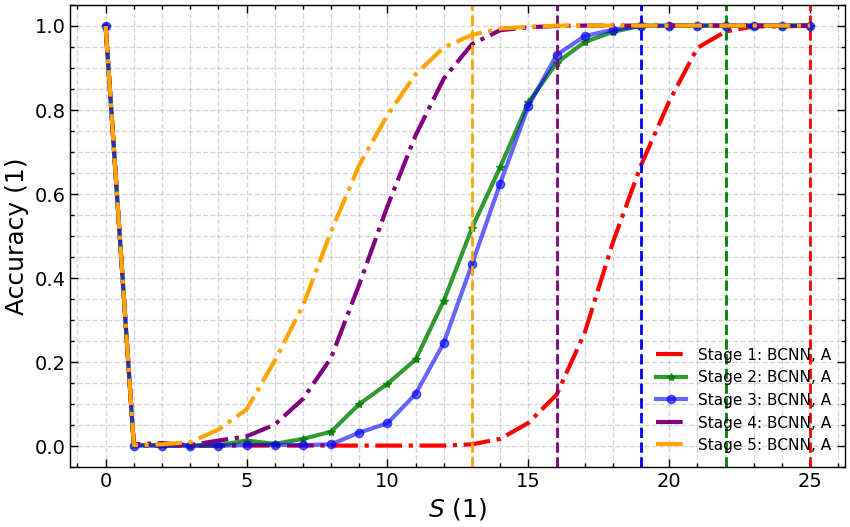

In [102]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_s0l_r1_A, "-.", color="red", linewidth=3, label = "Stage 1: BCNN, A", alpha = 1)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r2_A, "-*", color="green", linewidth=3,   label = "Stage 2: BCNN, A", alpha = 0.8)
plt.axvline(x=22, color='green', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r3_A, "-o", color="blue", linewidth=3,  label = "Stage 3: BCNN, A", alpha = 0.6)
plt.axvline(x=19, color='blue', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r4_A, "-.", color="purple", linewidth=3,  label = "Stage 4: BCNN, A")
plt.axvline(x=16, color='purple', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r5_A, "-.", color="orange", linewidth=3,  label = "Stage 5: BCNN, A")
plt.axvline(x=13, color='orange', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

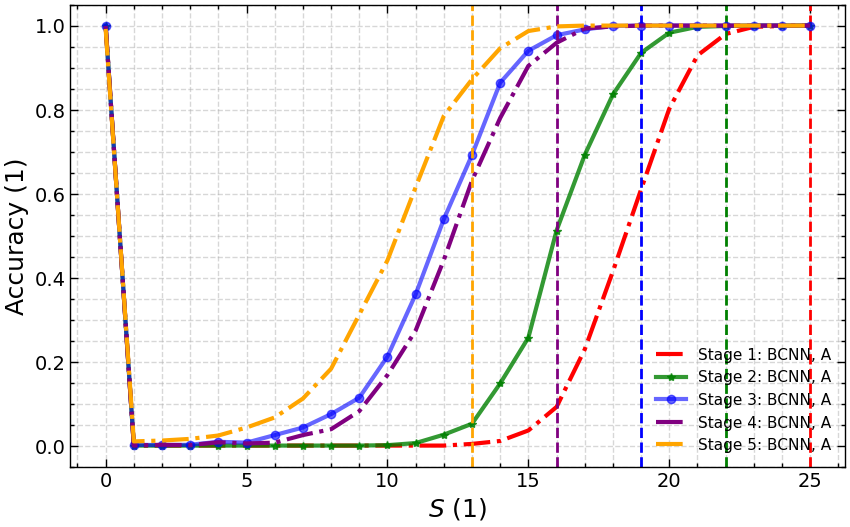

In [405]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_s0l_r1_A, "-.", color="red", linewidth=3, label = "Stage 1: BCNN, A", alpha = 1)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r2_A, "-*", color="green", linewidth=3,   label = "Stage 2: BCNN, A", alpha = 0.8)
plt.axvline(x=22, color='green', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r3_A, "-o", color="blue", linewidth=3,  label = "Stage 3: BCNN, A", alpha = 0.6)
plt.axvline(x=19, color='blue', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r4_A, "-.", color="purple", linewidth=3,  label = "Stage 4: BCNN, A")
plt.axvline(x=16, color='purple', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r5_A, "-.", color="orange", linewidth=3,  label = "Stage 5: BCNN, A")
plt.axvline(x=13, color='orange', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

In [342]:
with open('store/files/binary_classifier_spin0L_only/accuracy_vs_S_s0l_r1_r5_A.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r1_A': accuracy_s0l_r1_A,
        'accuracy_s0l_r2_A': accuracy_s0l_r2_A,
        'accuracy_s0l_r3_A': accuracy_s0l_r3_A,
        'accuracy_s0l_r4_A': accuracy_s0l_r4_A,
        'accuracy_s0l_r5_A': accuracy_s0l_r5_A
    }, f)

### B 

#### Model 1.

In [109]:
# Early stopping with restore_best_weights=True
early_stop_r1_B = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r1_B = 0.001
lr_schedule_r1_B = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r1_B, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r1_B      = BinaryClassifier(n)
optimizer_ns0l_r1_B = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r1_B)
model_s0l_r1_B.compile(optimizer=optimizer_ns0l_r1_B, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r1_B = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r1_B.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

Training: 1. run

In [111]:
history_r1_B = model_s0l_r1_B.fit(X_s0l_r1_B_train, y_s0l_r1_B_train, epochs=15, batch_size=32, validation_data=(X_s0l_r1_B_val, y_s0l_r1_B_val), verbose=2, callbacks=[early_stop_r1_B, checkpoint_r1_B])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.51500, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_B.keras
150/150 - 14s - 94ms/step - accuracy: 0.8900 - loss: 0.4242 - val_accuracy: 0.5150 - val_loss: 13.6582
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.51500
150/150 - 10s - 68ms/step - accuracy: 0.9769 - loss: 0.0633 - val_accuracy: 0.5150 - val_loss: 28.5622
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.51500
150/150 - 10s - 69ms/step - accuracy: 0.9829 - loss: 0.0472 - val_accuracy: 0.5150 - val_loss: 26.0168
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.51500
150/150 - 10s - 69ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.5150 - val_loss: 20.7948
Epoch 5/15

Epoch 5: val_accuracy improved from 0.51500 to 0.60667, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_B.keras
150/150 - 11s - 71ms/step - accuracy: 0.9910 - loss: 0.0294 - val_accuracy: 0.6067 - val_loss: 5.0640
Epoc

In [113]:
best_model_r1_B = load_model("store/files/binary_classifier_spin0L_only/best_model_r1_B.keras")
val_loss_s0l_r1_B, val_acc_s0l_r1_B = best_model_r1_B.evaluate(X_s0l_r1_B_val, y_s0l_r1_B_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r1_B:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9954 - loss: 0.0272
Restored Model - Validation Accuracy: 0.9942


#### Model 2.

In [115]:
# Early stopping with restore_best_weights=True
early_stop_r2_B = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r2_B = 0.001
lr_schedule_r2_B = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r2_B, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r2_B      = BinaryClassifier(n)
optimizer_ns0l_r2_B = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r2_B)
model_s0l_r2_B.compile(optimizer=optimizer_ns0l_r2_B, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r2_B = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r2_B.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [117]:
# upload weights
model_s0l_r2_B.set_weights(best_model_r1_B.get_weights())

Training: 2. run

In [119]:
history_r2_B = model_s0l_r2_B.fit(X_s0l_r2_B_train, y_s0l_r2_B_train, epochs=15, batch_size=32, validation_data=(X_s0l_r2_B_val, y_s0l_r2_B_val), verbose=2, callbacks=[early_stop_r2_B, checkpoint_r2_B])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.96792, saving model to store/files/binary_classifier_spin0L_only/best_model_r2_B.keras
300/300 - 28s - 95ms/step - accuracy: 0.9781 - loss: 0.0754 - val_accuracy: 0.9679 - val_loss: 0.0842
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.96792
300/300 - 36s - 121ms/step - accuracy: 0.9875 - loss: 0.0436 - val_accuracy: 0.9658 - val_loss: 0.0747
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.96792
300/300 - 20s - 67ms/step - accuracy: 0.9887 - loss: 0.0393 - val_accuracy: 0.5083 - val_loss: 7.8254
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.96792
300/300 - 21s - 69ms/step - accuracy: 0.9915 - loss: 0.0336 - val_accuracy: 0.5292 - val_loss: 5.6921
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.96792
300/300 - 21s - 68ms/step - accuracy: 0.9959 - loss: 0.0160 - val_accuracy: 0.9496 - val_loss: 0.1210
Epoch 6/15

Epoch 6: val_accuracy did not improve from 0.96792
300/300 - 20s - 68ms/step - a

In [121]:
best_model_r2_B = load_model("store/files/binary_classifier_spin0L_only/best_model_r2_B.keras")
val_loss_s0l_r2_B, val_acc_s0l_r2_B = best_model_r2_B.evaluate(X_s0l_r2_B_val, y_s0l_r2_B_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r2_B:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9710 - loss: 0.0749
Restored Model - Validation Accuracy: 0.9679


#### Model 3.

In [123]:
# Early stopping with restore_best_weights=True
early_stop_r3_B = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r3_B = 0.001
lr_schedule_r3_B = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r3_B, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r3_B      = BinaryClassifier(n)
optimizer_ns0l_r3_B = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r3_B)
model_s0l_r3_B.compile(optimizer=optimizer_ns0l_r3_B, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r3_B = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r3_B.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [125]:
# upload weights
model_s0l_r3_B.set_weights(best_model_r2_B.get_weights())

Training: 3. run

In [127]:
history_r3_B = model_s0l_r3_B.fit(X_s0l_r3_B_train, y_s0l_r3_B_train, epochs=15, batch_size=32, validation_data=(X_s0l_r3_B_val, y_s0l_r3_B_val), verbose=2, callbacks=[early_stop_r3_B, checkpoint_r3_B])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.72306, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_B.keras
450/450 - 35s - 77ms/step - accuracy: 0.9698 - loss: 0.1002 - val_accuracy: 0.7231 - val_loss: 0.5658
Epoch 2/15

Epoch 2: val_accuracy improved from 0.72306 to 0.91306, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_B.keras
450/450 - 39s - 88ms/step - accuracy: 0.9845 - loss: 0.0520 - val_accuracy: 0.9131 - val_loss: 0.7003
Epoch 3/15

Epoch 3: val_accuracy improved from 0.91306 to 0.98111, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_B.keras
450/450 - 31s - 68ms/step - accuracy: 0.9883 - loss: 0.0356 - val_accuracy: 0.9811 - val_loss: 0.0866
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.98111
450/450 - 30s - 68ms/step - accuracy: 0.9905 - loss: 0.0280 - val_accuracy: 0.9728 - val_loss: 0.1049
Epoch 5/15

Epoch 5: val_accuracy improved from 0.98111 to 0.98750, saving model to stor

In [129]:
best_model_r3_B = load_model("store/files/binary_classifier_spin0L_only/best_model_r3_B.keras")
val_loss_s0l_r3_B, val_acc_s0l_r3_B = best_model_r3_B.evaluate(X_s0l_r3_B_val, y_s0l_r3_B_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r3_B:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9885 - loss: 0.0749
Restored Model - Validation Accuracy: 0.9875


#### Model 4.

In [131]:
# Early stopping with restore_best_weights=True
early_stop_r4_B = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r4_B = 0.001
lr_schedule_r4_B = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r4_B, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r4_B      = BinaryClassifier(n)
optimizer_ns0l_r4_B = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r4_B)
model_s0l_r4_B.compile(optimizer=optimizer_ns0l_r4_B, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r4_B = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r4_B.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [133]:
# upload weights
model_s0l_r4_B.set_weights(best_model_r3_B.get_weights())

In [135]:
history_r4_B = model_s0l_r4_B.fit(X_s0l_r4_B_train, y_s0l_r4_B_train, epochs=15, batch_size=32, validation_data=(X_s0l_r4_B_val, y_s0l_r4_B_val), verbose=2, callbacks=[early_stop_r4_B, checkpoint_r4_B])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.68396, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_B.keras
600/600 - 54s - 91ms/step - accuracy: 0.9657 - loss: 0.1093 - val_accuracy: 0.6840 - val_loss: 11.3939
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.68396
600/600 - 81s - 136ms/step - accuracy: 0.9780 - loss: 0.0665 - val_accuracy: 0.4990 - val_loss: 9.2187
Epoch 3/15

Epoch 3: val_accuracy improved from 0.68396 to 0.91312, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_B.keras
600/600 - 47s - 78ms/step - accuracy: 0.9841 - loss: 0.0486 - val_accuracy: 0.9131 - val_loss: 0.7310
Epoch 4/15

Epoch 4: val_accuracy improved from 0.91312 to 0.93104, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_B.keras
600/600 - 82s - 136ms/step - accuracy: 0.9872 - loss: 0.0391 - val_accuracy: 0.9310 - val_loss: 0.1437
Epoch 5/15

Epoch 5: val_accuracy improved from 0.93104 to 0.94500, saving model to s

In [136]:
best_model_r4_B = load_model("store/files/binary_classifier_spin0L_only/best_model_r4_B.keras")
val_loss_s0l_r4_B, val_acc_s0l_r4_B = best_model_r4_B.evaluate(X_s0l_r4_B_val, y_s0l_r4_B_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r4_B:.4f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9816 - loss: 0.0579
Restored Model - Validation Accuracy: 0.9806


#### Model 5.

In [272]:
# Early stopping with restore_best_weights=True
early_stop_r5_B = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r5_B = 0.001
lr_schedule_r5_B = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r5_B, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r5_B      = BinaryClassifier(n)
optimizer_ns0l_r5_B = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r5_B)
model_s0l_r5_B.compile(optimizer=optimizer_ns0l_r5_B, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r5_B = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r5_B.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [274]:
# upload weights
model_s0l_r5_B.set_weights(best_model_r4_B.get_weights())

In [275]:
history_r5_B = model_s0l_r5_B.fit(X_s0l_r5_B_train, y_s0l_r5_B_train, epochs=15, batch_size=32, validation_data=(X_s0l_r5_B_val, y_s0l_r5_B_val), verbose=2, callbacks=[early_stop_r5_B, checkpoint_r5_B])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.63650, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_B.keras
750/750 - 68s - 91ms/step - accuracy: 0.9427 - loss: 0.1640 - val_accuracy: 0.6365 - val_loss: 2.3991
Epoch 2/15

Epoch 2: val_accuracy improved from 0.63650 to 0.93483, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_B.keras
750/750 - 79s - 106ms/step - accuracy: 0.9672 - loss: 0.0933 - val_accuracy: 0.9348 - val_loss: 0.1591
Epoch 3/15

Epoch 3: val_accuracy improved from 0.93483 to 0.95483, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_B.keras
750/750 - 54s - 72ms/step - accuracy: 0.9737 - loss: 0.0758 - val_accuracy: 0.9548 - val_loss: 0.1536
Epoch 4/15

Epoch 4: val_accuracy improved from 0.95483 to 0.96467, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_B.keras
750/750 - 55s - 73ms/step - accuracy: 0.9818 - loss: 0.0555 - val_accuracy: 0.9647 - val_loss: 0.1041
Ep

In [276]:
best_model_r5_B = load_model("store/files/binary_classifier_spin0L_only/best_model_r5_B.keras")
val_loss_s0l_r5_B, val_acc_s0l_r5_B = best_model_r5_B.evaluate(X_s0l_r5_B_val, y_s0l_r5_B_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r5_B:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9669 - loss: 0.0969
Restored Model - Validation Accuracy: 0.9647


Saving of weights

In [341]:
model_s0l_r1_B.save_weights('store/files/binary_classifier_spin0L_only/weights/B/model_s0l_r1_B.weights.h5')
model_s0l_r2_B.save_weights('store/files/binary_classifier_spin0L_only/weights/B/model_s0l_r2_B.weights.h5')
model_s0l_r3_B.save_weights('store/files/binary_classifier_spin0L_only/weights/B/model_s0l_r3_B.weights.h5')
model_s0l_r4_B.save_weights('store/files/binary_classifier_spin0L_only/weights/B/model_s0l_r4_B.weights.h5')
model_s0l_r5_B.save_weights('store/files/binary_classifier_spin0L_only/weights/B/model_s0l_r5_B.weights.h5')

### Evoluation

In [163]:
# this dataset will have S from 0 to 25 with step 1
snr_range_B = range(0, 25 + 1, 1)

Accuracy: 1. run

In [165]:
loss_s0l_r1_B     = []
accuracy_s0l_r1_B = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_B:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 1)
    res_example_normalized = scalar_s0l_B.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r1_B.evaluate(res_example_normalized, y_example)

    loss_s0l_r1_B.append(loss)
    accuracy_s0l_r1_B.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9945 - loss: 0.0350
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0134 - loss: 8.4622
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0200 - loss: 8.3382
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0297 - loss: 7.8614
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0309 - loss: 7.5373
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0299 - loss: 7.1421
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0659 - loss: 6.7112
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0741 - loss: 5.9559
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1038 - loss: 5.4457
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1288 - loss: 4.6914
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1983 - loss: 4.1282
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2306 - loss: 3.6434
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3153 - loss: 3.0355
13
32/32 

Accuracy: 2. run

In [166]:
loss_s0l_r2_B     = []
accuracy_s0l_r2_B = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_B:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 1)
    res_example_normalized = scalar_s0l_B.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r2_B.evaluate(res_example_normalized, y_example)

    loss_s0l_r2_B.append(loss)
    accuracy_s0l_r2_B.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9586 - loss: 0.1326
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0395 - loss: 7.9185
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0865 - loss: 7.2665
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0928 - loss: 6.6995
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0965 - loss: 6.4352
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1319 - loss: 5.6365
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1466 - loss: 5.3945
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2366 - loss: 4.1873
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2617 - loss: 3.7238
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3503 - loss: 3.1574
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4401 - loss: 2.2793
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5634 - loss: 1.9537
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6413 - loss: 1.2597
13
32/32 

Accuracy: 3. run

In [167]:
loss_s0l_r3_B     = []
accuracy_s0l_r3_B = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_B:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 1)
    res_example_normalized = scalar_s0l_B.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r3_B.evaluate(res_example_normalized, y_example)

    loss_s0l_r3_B.append(loss)
    accuracy_s0l_r3_B.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9996 - loss: 7.8032e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 27.2390
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 6.1713e-04 - loss: 24.8605
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0010 - loss: 24.8488
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 23.6870
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0034 - loss: 22.6363
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0035 - loss: 20.8279
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0136 - loss: 18.8352
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0235 - loss: 17.0052
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0490 - loss: 14.9232
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0982 - loss: 12.4142
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1457 - loss: 10.6664
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.23

Accuracy: 4. run

In [168]:
loss_s0l_r4_B     = []
accuracy_s0l_r4_B = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_B:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 1)
    res_example_normalized = scalar_s0l_B.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r4_B.evaluate(res_example_normalized, y_example)

    loss_s0l_r4_B.append(loss)
    accuracy_s0l_r4_B.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9886 - loss: 0.0219
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0051 - loss: 15.2946
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0077 - loss: 14.9797
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0070 - loss: 14.4627
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0278 - loss: 13.0598
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0249 - loss: 12.3054
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0427 - loss: 11.0296
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0856 - loss: 9.4332
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1307 - loss: 8.3541
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1877 - loss: 6.6706
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2831 - loss: 5.3906
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4240 - loss: 3.9742
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5284 - loss: 2.6312
13


Accuracy: 5. run

In [284]:
loss_s0l_r5_B     = []
accuracy_s0l_r5_B = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_B:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "white", nuis_control = 1)
    res_example_normalized = scalar_s0l_B.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r5_B.evaluate(res_example_normalized, y_example)

    loss_s0l_r5_B.append(loss)
    accuracy_s0l_r5_B.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9498 - loss: 0.1235
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0456 - loss: 7.5478
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0430 - loss: 7.3621
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0597 - loss: 6.8276
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0861 - loss: 6.2168
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1312 - loss: 5.3768
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2067 - loss: 4.5920
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2405 - loss: 4.0196
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3639 - loss: 3.0105
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4199 - loss: 2.5228
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5596 - loss: 1.6850
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6907 - loss: 1.2249
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7639 - loss: 0.8731
13
32/32 

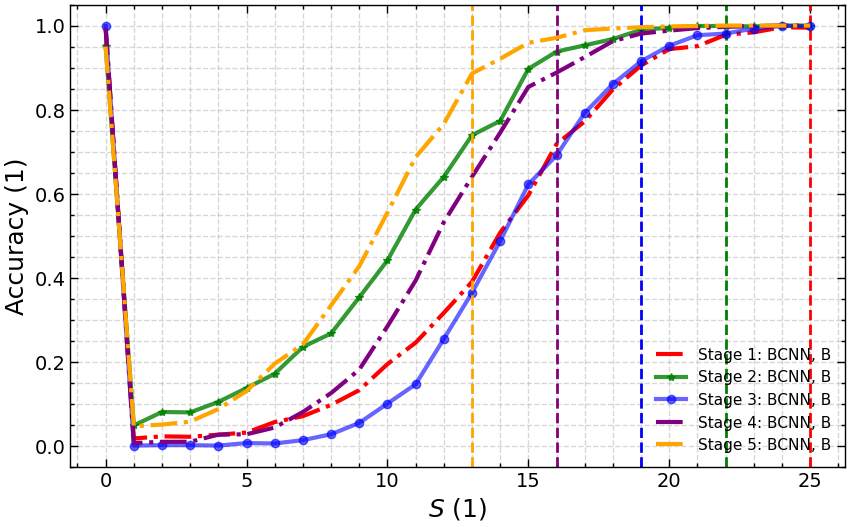

In [286]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_s0l_r1_B, "-.", color="red", linewidth=3, label = "Stage 1: BCNN, B", alpha = 1)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r2_B, "-*", color="green", linewidth=3,   label = "Stage 2: BCNN, B", alpha = 0.8)
plt.axvline(x=22, color='green', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r3_B, "-o", color="blue", linewidth=3,  label = "Stage 3: BCNN, B", alpha = 0.6)
plt.axvline(x=19, color='blue', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r4_B, "-.", color="purple", linewidth=3,  label = "Stage 4: BCNN, B")
plt.axvline(x=16, color='purple', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r5_B, "-.", color="orange", linewidth=3,  label = "Stage 5: BCNN, B")
plt.axvline(x=13, color='orange', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

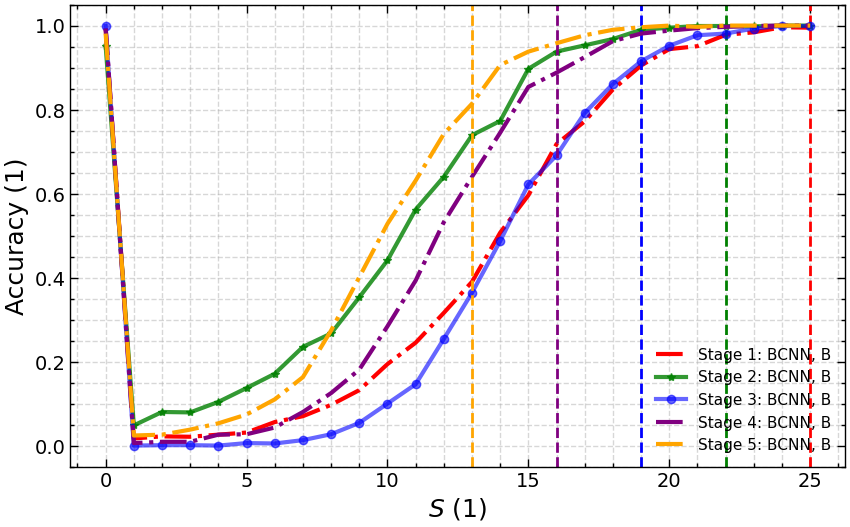

In [170]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_s0l_r1_B, "-.", color="red", linewidth=3, label = "Stage 1: BCNN, B", alpha = 1)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r2_B, "-*", color="green", linewidth=3,   label = "Stage 2: BCNN, B", alpha = 0.8)
plt.axvline(x=22, color='green', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r3_B, "-o", color="blue", linewidth=3,  label = "Stage 3: BCNN, B", alpha = 0.6)
plt.axvline(x=19, color='blue', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r4_B, "-.", color="purple", linewidth=3,  label = "Stage 4: BCNN, B")
plt.axvline(x=16, color='purple', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r5_B, "-.", color="orange", linewidth=3,  label = "Stage 5: BCNN, B")
plt.axvline(x=13, color='orange', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

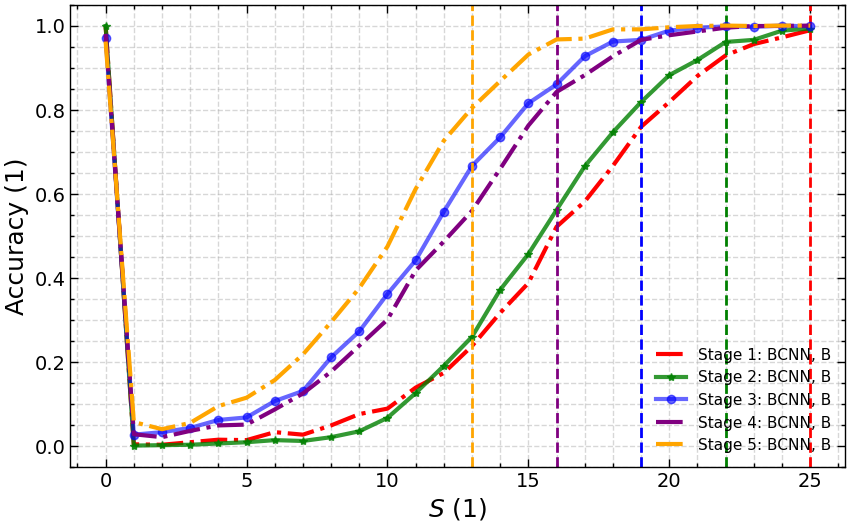

In [428]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_s0l_r1_B, "-.", color="red", linewidth=3, label = "Stage 1: BCNN, B", alpha = 1)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r2_B, "-*", color="green", linewidth=3,   label = "Stage 2: BCNN, B", alpha = 0.8)
plt.axvline(x=22, color='green', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r3_B, "-o", color="blue", linewidth=3,  label = "Stage 3: BCNN, B", alpha = 0.6)
plt.axvline(x=19, color='blue', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r4_B, "-.", color="purple", linewidth=3,  label = "Stage 4: BCNN, B")
plt.axvline(x=16, color='purple', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r5_B, "-.", color="orange", linewidth=3,  label = "Stage 5: BCNN, B")
plt.axvline(x=13, color='orange', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

In [339]:
with open('store/files/binary_classifier_spin0L_only/accuracy_vs_S_s0l_r1_r5_B.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r1_B': accuracy_s0l_r1_B,
        'accuracy_s0l_r2_B': accuracy_s0l_r2_B,
        'accuracy_s0l_r3_B': accuracy_s0l_r3_B,
        'accuracy_s0l_r4_B': accuracy_s0l_r4_B,
        'accuracy_s0l_r5_B': accuracy_s0l_r5_B
    }, f)

### C 

#### Model 1.

In [181]:
# Early stopping with restore_best_weights=True
early_stop_r1_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r1_C = 0.001
lr_schedule_r1_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r1_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r1_C      = BinaryClassifier(n)
optimizer_ns0l_r1_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r1_C)
model_s0l_r1_C.compile(optimizer=optimizer_ns0l_r1_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r1_C = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r1_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

Training: 1. run

In [183]:
history_r1_C = model_s0l_r1_C.fit(X_s0l_r1_C_train, y_s0l_r1_C_train, epochs=15, batch_size=32, validation_data=(X_s0l_r1_C_val, y_s0l_r1_C_val), verbose=2, callbacks=[early_stop_r1_C, checkpoint_r1_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.48500, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_C.keras
150/150 - 28s - 187ms/step - accuracy: 0.8998 - loss: 0.3616 - val_accuracy: 0.4850 - val_loss: 24.4739
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.48500
150/150 - 18s - 119ms/step - accuracy: 0.9848 - loss: 0.0454 - val_accuracy: 0.4850 - val_loss: 43.5634
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.48500
150/150 - 21s - 143ms/step - accuracy: 0.9860 - loss: 0.0359 - val_accuracy: 0.4850 - val_loss: 41.3565
Epoch 4/15

Epoch 4: val_accuracy improved from 0.48500 to 0.53750, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_C.keras
150/150 - 13s - 87ms/step - accuracy: 0.9902 - loss: 0.0325 - val_accuracy: 0.5375 - val_loss: 8.5303
Epoch 5/15

Epoch 5: val_accuracy improved from 0.53750 to 0.96917, saving model to store/files/binary_classifier_spin0L_only/best_model_r1_C.keras
150/150 - 20s - 130

In [184]:
best_model_r1_C = load_model("store/files/binary_classifier_spin0L_only/best_model_r1_C.keras")
val_loss_s0l_r1_C, val_acc_s0l_r1_C = best_model_r1_C.evaluate(X_s0l_r1_C_val, y_s0l_r1_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r1_C:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9995 - loss: 0.0015
Restored Model - Validation Accuracy: 0.9992


#### Model 2.

In [195]:
# Early stopping with restore_best_weights=True
early_stop_r2_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r2_C = 0.001
lr_schedule_r2_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r2_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r2_C      = BinaryClassifier(n)
optimizer_ns0l_r2_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r2_C)
model_s0l_r2_C.compile(optimizer=optimizer_ns0l_r2_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r2_C = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r2_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [197]:
# upload weights
model_s0l_r2_C.set_weights(best_model_r1_C.get_weights())

Training: 2. run

In [199]:
history_r2_C = model_s0l_r2_C.fit(X_s0l_r2_C_train, y_s0l_r2_C_train, epochs=15, batch_size=32, validation_data=(X_s0l_r2_C_val, y_s0l_r2_C_val), verbose=2, callbacks=[early_stop_r2_C, checkpoint_r2_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.99375, saving model to store/files/binary_classifier_spin0L_only/best_model_r2_C.keras
300/300 - 31s - 103ms/step - accuracy: 0.9915 - loss: 0.0360 - val_accuracy: 0.9937 - val_loss: 0.0243
Epoch 2/15

Epoch 2: val_accuracy improved from 0.99375 to 0.99708, saving model to store/files/binary_classifier_spin0L_only/best_model_r2_C.keras
300/300 - 41s - 135ms/step - accuracy: 0.9934 - loss: 0.0268 - val_accuracy: 0.9971 - val_loss: 0.0086
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.99708
300/300 - 23s - 77ms/step - accuracy: 0.9944 - loss: 0.0161 - val_accuracy: 0.7983 - val_loss: 1.9671
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.99708
300/300 - 41s - 137ms/step - accuracy: 0.9941 - loss: 0.0227 - val_accuracy: 0.9962 - val_loss: 0.0094
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.99708
300/300 - 41s - 137ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.9967 - val_loss: 0.0114
Epoc

In [201]:
best_model_r2_C = load_model("store/files/binary_classifier_spin0L_only/best_model_r2_C.keras")
val_loss_s0l_r2_C, val_acc_s0l_r2_C = best_model_r2_C.evaluate(X_s0l_r2_C_val, y_s0l_r2_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r2_C:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9977 - loss: 0.0074
Restored Model - Validation Accuracy: 0.9971


#### Model 3.

In [203]:
# Early stopping with restore_best_weights=True
early_stop_r3_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r3_C = 0.001
lr_schedule_r3_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r3_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r3_C      = BinaryClassifier(n)
optimizer_ns0l_r3_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r3_C)
model_s0l_r3_C.compile(optimizer=optimizer_ns0l_r3_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r3_C = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r3_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [205]:
# upload weights
model_s0l_r3_C.set_weights(best_model_r2_C.get_weights())

Training: 3. run

In [207]:
history_r3_C = model_s0l_r3_C.fit(X_s0l_r3_C_train, y_s0l_r3_C_train, epochs=15, batch_size=32, validation_data=(X_s0l_r3_C_val, y_s0l_r3_C_val), verbose=2, callbacks=[early_stop_r3_C, checkpoint_r3_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.53306, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_C.keras
450/450 - 43s - 96ms/step - accuracy: 0.9869 - loss: 0.0475 - val_accuracy: 0.5331 - val_loss: 2.1562
Epoch 2/15

Epoch 2: val_accuracy improved from 0.53306 to 0.82278, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_C.keras
450/450 - 40s - 89ms/step - accuracy: 0.9919 - loss: 0.0258 - val_accuracy: 0.8228 - val_loss: 1.3457
Epoch 3/15

Epoch 3: val_accuracy improved from 0.82278 to 0.95611, saving model to store/files/binary_classifier_spin0L_only/best_model_r3_C.keras
450/450 - 35s - 77ms/step - accuracy: 0.9934 - loss: 0.0221 - val_accuracy: 0.9561 - val_loss: 0.1542
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.95611
450/450 - 41s - 91ms/step - accuracy: 0.9941 - loss: 0.0194 - val_accuracy: 0.8069 - val_loss: 2.5446
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.95611
450/450 - 41s - 91ms/step

In [209]:
best_model_r3_C = load_model("store/files/binary_classifier_spin0L_only/best_model_r3_C.keras")
val_loss_s0l_r3_C, val_acc_s0l_r3_C = best_model_r3_C.evaluate(X_s0l_r3_C_val, y_s0l_r3_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r3_C:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9968 - loss: 0.0099
Restored Model - Validation Accuracy: 0.9975


#### Model 4.

In [211]:
# Early stopping with restore_best_weights=True
early_stop_r4_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r4_C = 0.001
lr_schedule_r4_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r4_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r4_C      = BinaryClassifier(n)
optimizer_ns0l_r4_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r4_C)
model_s0l_r4_C.compile(optimizer=optimizer_ns0l_r4_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r4_C = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r4_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [213]:
# upload weights
model_s0l_r4_C.set_weights(best_model_r3_C.get_weights())

In [215]:
history_r4_C = model_s0l_r4_C.fit(X_s0l_r4_C_train, y_s0l_r4_C_train, epochs=15, batch_size=32, validation_data=(X_s0l_r4_C_val, y_s0l_r4_C_val), verbose=2, callbacks=[early_stop_r4_C, checkpoint_r4_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.99125, saving model to store/files/binary_classifier_spin0L_only/best_model_r4_C.keras
600/600 - 63s - 105ms/step - accuracy: 0.9871 - loss: 0.0486 - val_accuracy: 0.9912 - val_loss: 0.0286
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.99125
600/600 - 77s - 128ms/step - accuracy: 0.9906 - loss: 0.0315 - val_accuracy: 0.9552 - val_loss: 0.2712
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.99125
600/600 - 83s - 139ms/step - accuracy: 0.9930 - loss: 0.0248 - val_accuracy: 0.9048 - val_loss: 0.3397
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.99125
600/600 - 53s - 88ms/step - accuracy: 0.9941 - loss: 0.0204 - val_accuracy: 0.9556 - val_loss: 0.2319
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.99125
600/600 - 43s - 72ms/step - accuracy: 0.9946 - loss: 0.0206 - val_accuracy: 0.5663 - val_loss: 1.2659
Epoch 6/15

Epoch 6: val_accuracy did not improve from 0.99125
600/600 - 88s - 147ms/step 

In [217]:
best_model_r4_C = load_model("store/files/binary_classifier_spin0L_only/best_model_r4_C.keras")
val_loss_s0l_r4_C, val_acc_s0l_r4_C = best_model_r4_C.evaluate(X_s0l_r4_C_val, y_s0l_r4_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r4_C:.4f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9937 - loss: 0.0239
Restored Model - Validation Accuracy: 0.9912


#### Model 5.

In [219]:
# Early stopping with restore_best_weights=True
early_stop_r5_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r5_C = 0.001
lr_schedule_r5_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r5_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r5_C      = BinaryClassifier(n)
optimizer_ns0l_r5_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r5_C)
model_s0l_r5_C.compile(optimizer=optimizer_ns0l_r5_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r5_C = ModelCheckpoint(
    "store/files/binary_classifier_spin0L_only/best_model_r5_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [221]:
# upload weights
model_s0l_r5_C.set_weights(best_model_r4_C.get_weights())

In [223]:
history_r5_C = model_s0l_r5_C.fit(X_s0l_r5_C_train, y_s0l_r5_C_train, epochs=15, batch_size=32, validation_data=(X_s0l_r5_C_val, y_s0l_r5_C_val), verbose=2, callbacks=[early_stop_r5_C, checkpoint_r5_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.92317, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_C.keras
750/750 - 67s - 90ms/step - accuracy: 0.9699 - loss: 0.0944 - val_accuracy: 0.9232 - val_loss: 0.1720
Epoch 2/15

Epoch 2: val_accuracy improved from 0.92317 to 0.98483, saving model to store/files/binary_classifier_spin0L_only/best_model_r5_C.keras
750/750 - 56s - 74ms/step - accuracy: 0.9817 - loss: 0.0526 - val_accuracy: 0.9848 - val_loss: 0.0539
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.98483
750/750 - 59s - 78ms/step - accuracy: 0.9869 - loss: 0.0418 - val_accuracy: 0.6907 - val_loss: 7.2328
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.98483
750/750 - 59s - 79ms/step - accuracy: 0.9891 - loss: 0.0350 - val_accuracy: 0.9025 - val_loss: 0.4602
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.98483
750/750 - 59s - 79ms/step - accuracy: 0.9914 - loss: 0.0255 - val_accuracy: 0.9533 - val_loss: 0.1749
Epoch 6/

In [225]:
best_model_r5_C = load_model("store/files/binary_classifier_spin0L_only/best_model_r5_C.keras")
val_loss_s0l_r5_C, val_acc_s0l_r5_C = best_model_r5_C.evaluate(X_s0l_r5_C_val, y_s0l_r5_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_s0l_r5_C:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9872 - loss: 0.0477
Restored Model - Validation Accuracy: 0.9868


Saving of weights

In [337]:
model_s0l_r1_C.save_weights('store/files/binary_classifier_spin0L_only/weights/C/model_s0l_r1_C.weights.h5')
model_s0l_r2_C.save_weights('store/files/binary_classifier_spin0L_only/weights/C/model_s0l_r2_C.weights.h5')
model_s0l_r3_C.save_weights('store/files/binary_classifier_spin0L_only/weights/C/model_s0l_r3_C.weights.h5')
model_s0l_r4_C.save_weights('store/files/binary_classifier_spin0L_only/weights/C/model_s0l_r4_C.weights.h5')
model_s0l_r5_C.save_weights('store/files/binary_classifier_spin0L_only/weights/C/model_s0l_r5_C.weights.h5')

### Evaluation

In [228]:
# this dataset will have S from 0 to 25 with step 1
snr_range_C = range(0, 25 + 1, 1)

Accuracy: 1. run

In [230]:
loss_s0l_r1_C     = []
accuracy_s0l_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_C:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scalar_s0l_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r1_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r1_C.append(loss)
    accuracy_s0l_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9985 - loss: 0.0028
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0018 - loss: 23.6571
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0057 - loss: 22.0371
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0107 - loss: 21.6578
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0132 - loss: 20.3168
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0149 - loss: 19.3497
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0358 - loss: 17.2649
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0544 - loss: 15.4499
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0892 - loss: 13.2225
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1155 - loss: 11.2709
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2162 - loss: 8.7902
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3072 - loss: 6.5122
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4130 - loss: 4.8983


Accuracy: 2. run

In [233]:
loss_s0l_r2_C     = []
accuracy_s0l_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_C:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scalar_s0l_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r2_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r2_C.append(loss)
    accuracy_s0l_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.6316e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 27.0091
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 27.0938
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 3.7920e-04 - loss: 26.3201
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 8.5474e-04 - loss: 24.7246
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0010 - loss: 22.5210    
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0030 - loss: 21.7241
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0111 - loss: 19.4950
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0172 - loss: 16.8990
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0463 - loss: 14.3977
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0557 - loss: 12.9502
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1299 - loss: 9.9398
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accurac

Accuracy: 3. run

In [234]:
loss_s0l_r3_C     = []
accuracy_s0l_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_C:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scalar_s0l_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r3_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r3_C.append(loss)
    accuracy_s0l_r3_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0032
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 7.9263e-04 - loss: 23.4450
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0016 - loss: 22.7761
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 7.9515e-04 - loss: 22.1024
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0023 - loss: 19.6023
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0088 - loss: 18.7720
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0142 - loss: 16.1819
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0351 - loss: 14.6015
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0785 - loss: 11.6465
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1267 - loss: 9.6145
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2568 - loss: 7.0689
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3580 - loss: 5.7383
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4826 - loss: 

Accuracy: 4. run

In [235]:
loss_s0l_r4_C     = []
accuracy_s0l_r4_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_C:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scalar_s0l_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r4_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r4_C.append(loss)
    accuracy_s0l_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9888 - loss: 0.0473
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0107 - loss: 21.5333
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0207 - loss: 20.3579
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0292 - loss: 19.4186
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0600 - loss: 17.7419
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0847 - loss: 15.0237
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1216 - loss: 12.7361
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2262 - loss: 9.8876
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3705 - loss: 6.3900
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5071 - loss: 5.0949
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6483 - loss: 2.9924
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7718 - loss: 1.6109
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8775 - loss: 0.9032
13


Accuracy: 5. run

In [236]:
loss_s0l_r5_C     = []
accuracy_s0l_r5_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range_C:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scalar_s0l_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r5_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r5_C.append(loss)
    accuracy_s0l_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9892 - loss: 0.0303
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0166 - loss: 17.4315
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0118 - loss: 17.1417
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0103 - loss: 16.0460
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0284 - loss: 14.6096
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0605 - loss: 12.1493
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1053 - loss: 9.8245
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1963 - loss: 8.1395
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3519 - loss: 5.6510
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4440 - loss: 3.9622
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6230 - loss: 2.2282
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7697 - loss: 1.3250
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8528 - loss: 0.6403
13
3

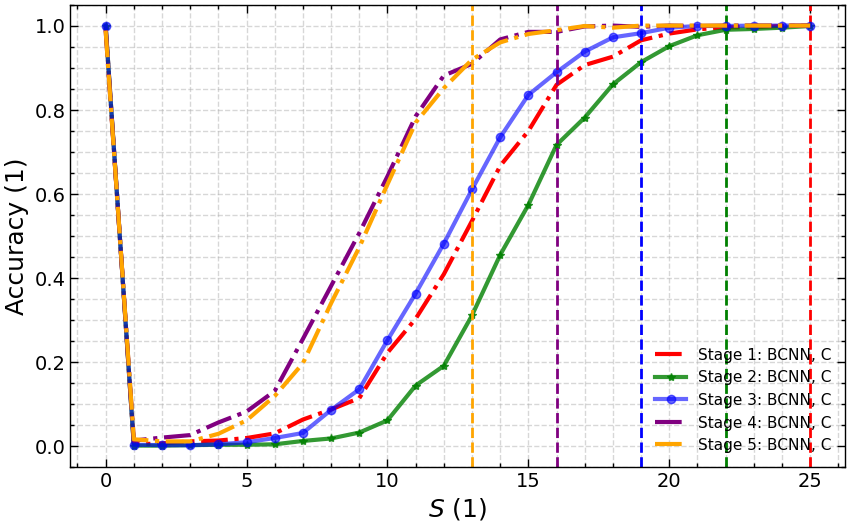

In [237]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_s0l_r1_C, "-.", color="red", linewidth=3, label = "Stage 1: BCNN, C", alpha = 1)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r2_C, "-*", color="green", linewidth=3,   label = "Stage 2: BCNN, C", alpha = 0.8)
plt.axvline(x=22, color='green', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r3_C, "-o", color="blue", linewidth=3,  label = "Stage 3: BCNN, C", alpha = 0.6)
plt.axvline(x=19, color='blue', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r4_C, "-.", color="purple", linewidth=3,  label = "Stage 4: BCNN, C")
plt.axvline(x=16, color='purple', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r5_C, "-.", color="orange", linewidth=3,  label = "Stage 5: BCNN, C")
plt.axvline(x=13, color='orange', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

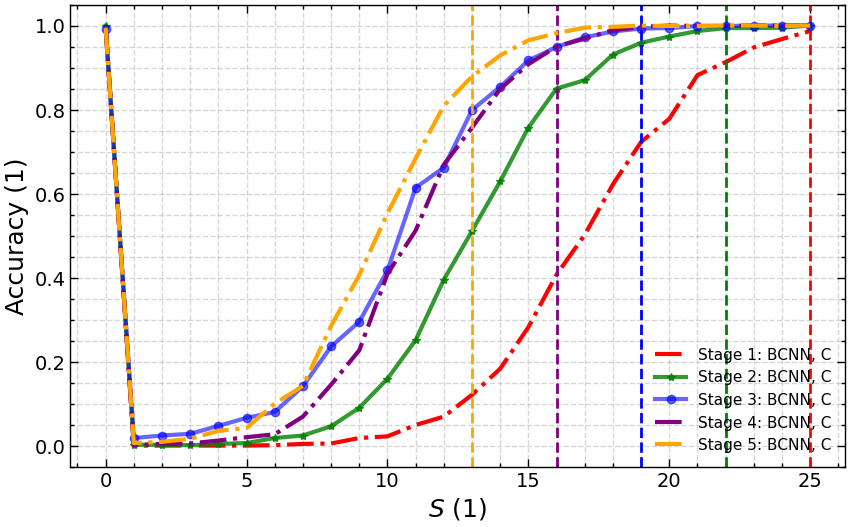

In [440]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_s0l_r1_C, "-.", color="red", linewidth=3, label = "Stage 1: BCNN, C", alpha = 1)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r2_C, "-*", color="green", linewidth=3,   label = "Stage 2: BCNN, C", alpha = 0.8)
plt.axvline(x=22, color='green', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r3_C, "-o", color="blue", linewidth=3,  label = "Stage 3: BCNN, C", alpha = 0.6)
plt.axvline(x=19, color='blue', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r4_C, "-.", color="purple", linewidth=3,  label = "Stage 4: BCNN, C")
plt.axvline(x=16, color='purple', linestyle='--', linewidth=2)

plt.plot(accuracy_s0l_r5_C, "-.", color="orange", linewidth=3,  label = "Stage 5: BCNN, C")
plt.axvline(x=13, color='orange', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

In [335]:
with open('store/files/binary_classifier_spin0L_only/accuracy_vs_S_s0l_r1_r5_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r1_C': accuracy_s0l_r1_C,
        'accuracy_s0l_r2_C': accuracy_s0l_r2_C,
        'accuracy_s0l_r3_C': accuracy_s0l_r3_C,
        'accuracy_s0l_r4_C': accuracy_s0l_r4_C,
        'accuracy_s0l_r5_C': accuracy_s0l_r5_C
    }, f)

### Comparion between A, B and C 

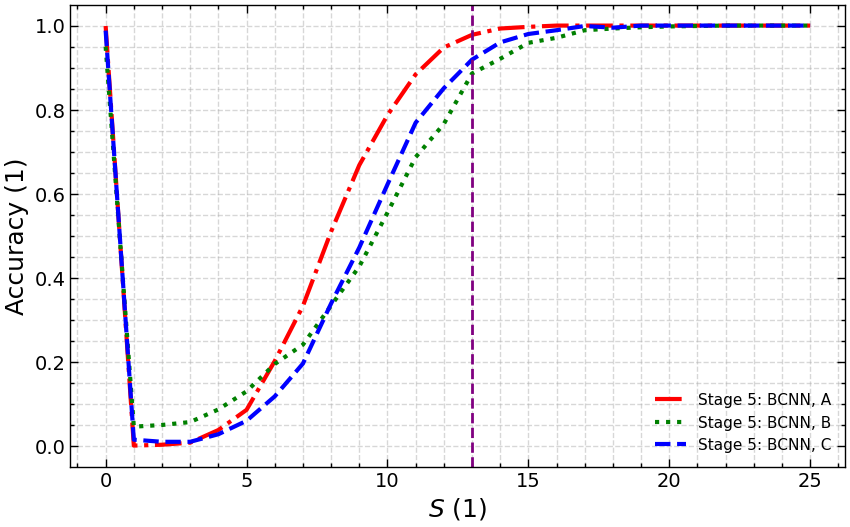

In [290]:
plt.figure(figsize=(10, 6))


plt.plot(accuracy_s0l_r5_A, "-.", color="red", linewidth=3,  label = "Stage 5: BCNN, A")
plt.plot(accuracy_s0l_r5_B, ":", color="green", linewidth=3,  label = "Stage 5: BCNN, B")
plt.plot(accuracy_s0l_r5_C, "--", color="blue", linewidth=3,  label = "Stage 5: BCNN, C")

plt.axvline(x=13, color='purple', linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel(r"$S$ (1)", fontsize=18)
plt.ylabel("Accuracy (1)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='best')

plt.show()

# 8 Performance on different masses

In [292]:
m_exp_interval = np.arange(-23,-18 + 0.2, 0.2)
m_interval     = 10**(m_exp_interval) * u.eV
len(m_exp_interval)

26

### A

In [294]:
loss_s0l_A_m_all     = []
accuracy_s0l_A_m_all = []
S_A_all              = []

for m_i in tqdm(m_interval):

    print("----")
    print(m_i)
    
    loss_s0l_m     = []
    accuracy_s0l_m = []
    
    # masses are randomly selected from the interval mmin to mmax
    j = 0
    while j <= 150:
        
        print(j)
        
        res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [m_i, m_i], snr = j, spin = "s0l", noise_model = "white", nuis_control = 0)
        res_example_normalized = scalar_s0l_A.transform(res_example)
    
        if j == 0:
            y_example = np.zeros(len(res_example)).reshape(-1,1)
        else:
            y_example = np.ones(len(res_example)).reshape(-1,1)
    
        loss, accuracy = best_model_r5_A.evaluate(res_example_normalized, y_example)
    
        loss_s0l_A_m_all.append(loss)
        accuracy_s0l_A_m_all.append(accuracy)

        if j == 150 and accuracy < 0.99:
            S_A_all.append(None)
        
        if accuracy >= 0.99 and j != 0:
            S_A_all.append(j)
            print("S_crit = ", S_A_all[-1])
            j=150
        
        j+=1

    loss_s0l_A_m_all.append(loss_s0l_A_m_all)
    accuracy_s0l_A_m_all.append(accuracy_s0l_A_m_all)

  0%|          | 0/26 [00:00<?, ?it/s]

----
1e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9992 - loss: 0.0016
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 31.7163
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0021 - loss: 31.4816
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0207 - loss: 27.7846
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0426 - loss: 24.6783
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0991 - loss: 19.4345
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2034 - loss: 14.8152
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4044 - loss: 9.7705
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5436 - loss: 6.3037
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7236 - loss: 3.0006
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8447 - loss: 1.3986
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9057 - loss: 0.6990
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9468 

  4%|▍         | 1/26 [01:07<28:15, 67.84s/it]

S_crit =  14
----
1.584893192461111e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9991 - loss: 0.0050
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 8.6279e-04 - loss: 32.4426
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0041 - loss: 31.4070
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0108 - loss: 27.5985
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0451 - loss: 24.4317
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1307 - loss: 19.2118
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1715 - loss: 15.5017
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3495 - loss: 11.2073
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4977 - loss: 7.4918
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6996 - loss: 3.5348
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8214 - loss: 1.8684
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8935 - loss: 0.9684
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s

  8%|▊         | 2/26 [02:20<28:18, 70.78s/it]

S_crit =  14
----
2.511886431509572e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 5.6540e-05
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0029 - loss: 31.8904
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0039 - loss: 29.9019
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0170 - loss: 28.9737
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0316 - loss: 25.3629
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0849 - loss: 20.9188
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1552 - loss: 16.9283
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3183 - loss: 11.5471
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4832 - loss: 7.3872
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6910 - loss: 3.4773
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8132 - loss: 1.7076
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8902 - loss: 0.9106
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 12%|█▏        | 3/26 [03:23<25:46, 67.25s/it]

S_crit =  14
----
3.981071705534953e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.0949e-05
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0017 - loss: 32.0167
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0014 - loss: 29.8410  
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0046 - loss: 28.4201
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0215 - loss: 25.7904
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0827 - loss: 21.5617
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1780 - loss: 15.6452
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2946 - loss: 11.7009
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4499 - loss: 8.1941
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6722 - loss: 3.4882
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7895 - loss: 2.0350
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8976 - loss: 0.7638
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 

 15%|█▌        | 4/26 [04:30<24:33, 67.00s/it]

S_crit =  14
----
6.309573444801891e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.3535e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0019 - loss: 31.5763
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0066 - loss: 30.9030
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0160 - loss: 27.8061
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0309 - loss: 25.2217
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0931 - loss: 20.5350
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2219 - loss: 14.9911
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3413 - loss: 10.5789
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5576 - loss: 5.7825
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6528 - loss: 3.8520
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8239 - loss: 1.5908
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9069 - loss: 0.8368
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 19%|█▉        | 5/26 [05:40<23:53, 68.27s/it]

S_crit =  14
----
9.999999999999918e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.0029e-05
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0012 - loss: 32.0030  
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.8919e-04 - loss: 31.1947
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0089 - loss: 28.0549
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0251 - loss: 26.1043
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0773 - loss: 21.0552
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1912 - loss: 15.1958
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3311 - loss: 10.9182
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5189 - loss: 6.9187
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6645 - loss: 4.1575
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8202 - loss: 1.7702
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8986 - loss: 0.7488
12
32/32 ━━━━━━━━━━━━━━━━━

 23%|██▎       | 6/26 [06:40<21:48, 65.44s/it]

S_crit =  14
----
1.584893192461098e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9983 - loss: 0.0019
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0027 - loss: 31.4358
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0087 - loss: 30.3174
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0105 - loss: 28.3427
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0330 - loss: 25.2438
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0741 - loss: 20.3112
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1899 - loss: 15.9973
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3311 - loss: 11.2411
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4955 - loss: 6.5124
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6635 - loss: 3.8798
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7893 - loss: 1.7565
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8719 - loss: 0.9160
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13m

 27%|██▋       | 7/26 [07:39<20:00, 63.18s/it]

S_crit =  14
----
2.511886431509551e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.5181e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0060 - loss: 31.0730
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0021 - loss: 31.0572
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0041 - loss: 28.8808
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0342 - loss: 24.8454
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0928 - loss: 20.3914
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1522 - loss: 15.9420
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3376 - loss: 10.4982
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5535 - loss: 6.3490
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6870 - loss: 3.8028
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7882 - loss: 2.0732
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9265 - loss: 0.5699
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 31%|███       | 8/26 [08:48<19:29, 64.95s/it]

S_crit =  14
----
3.98107170553492e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 7.5553e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 32.3855
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0088 - loss: 29.6500
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0095 - loss: 28.9657
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0274 - loss: 25.4140
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0686 - loss: 21.2051
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2117 - loss: 15.2005
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3248 - loss: 11.2433
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5133 - loss: 6.2393
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6733 - loss: 3.4192
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8145 - loss: 1.5717
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9015 - loss: 0.6761
12
32/32 ━━━━━━━━━━━━━━━━━━━━

 35%|███▍      | 9/26 [09:49<18:05, 63.87s/it]

S_crit =  14
----
6.309573444801839e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9988 - loss: 0.0030
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 31.7819
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0047 - loss: 30.2916
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0145 - loss: 28.5962
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0463 - loss: 25.1378
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0805 - loss: 20.2833
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1580 - loss: 16.5839
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3466 - loss: 10.4834
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5109 - loss: 7.1916
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6894 - loss: 3.4485
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8067 - loss: 1.6365
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8846 - loss: 0.9805
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 38%|███▊      | 10/26 [10:53<17:01, 63.82s/it]

S_crit =  14
----
9.999999999999837e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9996 - loss: 6.8473e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0019 - loss: 32.0284
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0024 - loss: 30.8265
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0166 - loss: 29.0095
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0223 - loss: 25.3864
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0882 - loss: 21.4396
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1585 - loss: 16.6341
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2899 - loss: 12.2001
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4450 - loss: 7.7938
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6074 - loss: 4.6337
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7176 - loss: 3.1888
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8595 - loss: 1.1561
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 42%|████▏     | 11/26 [12:02<16:22, 65.50s/it]

S_crit =  15
----
1.584893192461085e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9961 - loss: 0.0038
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0029 - loss: 31.8579
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0034 - loss: 30.8353
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0102 - loss: 29.3085
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0134 - loss: 26.6562
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0699 - loss: 23.7099
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1241 - loss: 19.7363
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2234 - loss: 15.6231
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3775 - loss: 11.7034
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4424 - loss: 9.8520
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5947 - loss: 6.5466
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6850 - loss: 4.6651
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13

 46%|████▌     | 12/26 [13:25<16:32, 70.92s/it]

S_crit =  20
----
2.511886431509531e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9992 - loss: 0.0029
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 31.8479
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0018 - loss: 30.8803
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0100 - loss: 30.2384
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0132 - loss: 29.1428
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0343 - loss: 26.3282
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1078 - loss: 21.7486
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1597 - loss: 19.5352
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2970 - loss: 15.2326
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3713 - loss: 12.8039
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4911 - loss: 9.8460
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6070 - loss: 6.8405
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 

 50%|█████     | 13/26 [15:14<17:50, 82.34s/it]

S_crit =  25
----
3.981071705534888e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.0622e-06
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0014 - loss: 32.3083  
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 8.9388e-04 - loss: 31.1320
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0047 - loss: 31.0271
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0141 - loss: 29.8091
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0361 - loss: 27.9779
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0652 - loss: 25.9368
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1270 - loss: 23.3700
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1964 - loss: 20.9080
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2966 - loss: 16.8468
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3840 - loss: 15.0633
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4716 - loss: 12.8998
12
32/32 ━━━━━━━━━━━━━

 54%|█████▍    | 14/26 [28:10<58:22, 291.86s/it]

----
6.309573444801788e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9993 - loss: 0.0040
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 3.3802e-04 - loss: 31.8199
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0029 - loss: 32.1737
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0083 - loss: 31.1594
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0115 - loss: 29.7967
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0436 - loss: 27.9215
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0656 - loss: 26.5471
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0813 - loss: 23.4905
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1918 - loss: 20.0318
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2512 - loss: 17.9222
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3508 - loss: 16.2359
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4207 - loss: 14.4148
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/ste

 58%|█████▊    | 15/26 [34:50<59:29, 324.46s/it]

S_crit =  82
----
9.999999999999754e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9986 - loss: 0.0092
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0039 - loss: 32.0467
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.0829e-04 - loss: 30.4834
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0056 - loss: 28.9068
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0157 - loss: 27.2735
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0381 - loss: 25.1040
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0999 - loss: 20.4543
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1186 - loss: 18.1123
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2492 - loss: 13.2829
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4126 - loss: 9.8825
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4592 - loss: 8.2124
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5850 - loss: 5.2719
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

 62%|██████▏   | 16/26 [36:39<43:14, 259.49s/it]

S_crit =  20
----
1.584893192461072e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.3529e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0017 - loss: 32.5268
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 6.0606e-05 - loss: 31.7920
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0027 - loss: 32.1687
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0146 - loss: 31.6520
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0017 - loss: 31.7687  
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0124 - loss: 29.7187
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0344 - loss: 28.6587
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0431 - loss: 28.0765
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0711 - loss: 26.8366
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0706 - loss: 26.1480
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0943 - loss: 24.6407
12
32/32 ━━━━━━━━━━━━━

 65%|██████▌   | 17/26 [43:06<44:42, 298.07s/it]

S_crit =  89
----
2.5118864315095104e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9989 - loss: 0.0025
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0019 - loss: 32.7170
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0019 - loss: 31.7240
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0014 - loss: 32.3514
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 4.6733e-04 - loss: 31.6651
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0014 - loss: 30.8334
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0032 - loss: 30.1724
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0060 - loss: 29.5396
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0078 - loss: 28.3406
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0111 - loss: 27.6882
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0151 - loss: 26.4504
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0216 - loss: 25.6291
12
32/32 ━━━━━━━━━━━━━━━━━━

 69%|██████▉   | 18/26 [46:12<35:14, 264.30s/it]

S_crit =  43
----
3.9810717055348555e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5.9442e-05
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0025 - loss: 32.8128
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 8.0633e-04 - loss: 32.2180
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 7.5372e-04 - loss: 31.6267
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 3.7920e-04 - loss: 32.6023
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0033 - loss: 32.7925
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 9.1153e-05 - loss: 34.0252
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0044 - loss: 31.9127
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0062 - loss: 33.3699
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0028 - loss: 33.1239
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 8.6279e-04 - loss: 34.3341
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0097 - loss: 33.9993
12
32/3

 73%|███████▎  | 19/26 [56:36<43:26, 372.29s/it]

----
6.309573444801736e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9998 - loss: 0.0018    
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 2.6069e-04 - loss: 32.0248
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0029 - loss: 32.0921
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0040 - loss: 31.8292
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0060 - loss: 30.0251
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0196 - loss: 29.0534
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0411 - loss: 27.7775
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0668 - loss: 25.1415
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0904 - loss: 23.3623
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1557 - loss: 20.9475
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2321 - loss: 18.9331
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2784 - loss: 16.7279
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms

 77%|███████▋  | 20/26 [59:45<31:42, 317.15s/it]

S_crit =  44
----
9.999999999999672e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0010    
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 31.9621
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0064 - loss: 32.2145
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0112 - loss: 29.7014
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0218 - loss: 29.7088
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0540 - loss: 26.7420
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0894 - loss: 25.3669
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1746 - loss: 21.0498
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2352 - loss: 19.9201
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3184 - loss: 18.0021
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4200 - loss: 16.1323
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4939 - loss: 13.9993
12
32/32 ━━━━━━━━━━━━━━━

 81%|████████  | 21/26 [1:10:06<34:01, 408.40s/it]

----
1.5848931924610591e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9983 - loss: 0.0066 
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 9.1153e-05 - loss: 31.5675
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0049 - loss: 30.6550
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0133 - loss: 29.3552
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0565 - loss: 26.4429
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1167 - loss: 22.9304
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1961 - loss: 19.2340
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2994 - loss: 15.5673
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4630 - loss: 11.4119
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5765 - loss: 10.0528
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6676 - loss: 8.3160
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7255 - loss: 6.8295
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

 85%|████████▍ | 22/26 [1:13:34<23:13, 348.39s/it]

S_crit =  49
----
2.51188643150949e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9981 - loss: 0.0198
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0028 - loss: 31.3832
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0061 - loss: 30.8052
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0265 - loss: 28.3316
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0677 - loss: 25.0304
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1401 - loss: 20.5727
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2878 - loss: 16.0720
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4097 - loss: 11.7589
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5661 - loss: 8.9138
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6982 - loss: 5.9657
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7799 - loss: 5.4201
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8026 - loss: 4.2778
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms

 88%|████████▊ | 23/26 [1:16:53<15:10, 303.38s/it]

S_crit =  47
----
3.9810717055348226e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9987 - loss: 0.0041 
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 5.6839e-04 - loss: 32.1939
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0081 - loss: 31.1603
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0282 - loss: 27.7017
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0701 - loss: 24.9089
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1963 - loss: 19.1315
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3336 - loss: 13.4947
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5068 - loss: 9.3289
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6738 - loss: 6.1344
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7708 - loss: 4.8761
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8484 - loss: 3.4687
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8637 - loss: 3.1547
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

 92%|█████████▏| 24/26 [1:19:47<08:49, 264.59s/it]

S_crit =  42
----
6.309573444801685e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.9204e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0014 - loss: 31.6456
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0039 - loss: 31.4475
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0337 - loss: 27.7514
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0930 - loss: 23.0881
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2031 - loss: 18.0645
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3773 - loss: 11.8730
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6100 - loss: 6.6974
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7860 - loss: 3.7191
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8364 - loss: 3.1035
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9039 - loss: 1.9871
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9272 - loss: 1.2589
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

 96%|█████████▌| 25/26 [1:21:41<03:39, 219.35s/it]

S_crit =  27
----
9.99999999999959e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011  
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0018 - loss: 32.3362
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0061 - loss: 29.3028
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0283 - loss: 27.5457
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0810 - loss: 22.7905
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2013 - loss: 16.8215
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3986 - loss: 10.7564
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6287 - loss: 6.0476
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7905 - loss: 3.5329
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8636 - loss: 2.8277
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9267 - loss: 1.8833
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9389 - loss: 1.8306
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

100%|██████████| 26/26 [1:24:10<00:00, 194.25s/it]

S_crit =  36


In [333]:
directory_S_m_accuracy_A = {'S_A_all': S_A_all, 'm_interval': m_interval, 'accuracy_s0l_A_m_all': accuracy_s0l_A_m_all}

# Save the dictionary as a binary file
with open('store/files/binary_classifier_spin0L_only/directory_S_m_accuracy_A.pkl', "wb") as file:
    pickle.dump(directory_S_m_accuracy_A, file)

print("Dictionary saved successfully!")

Dictionary saved successfully!


### B

In [317]:
loss_s0l_B_m_all     = []
accuracy_s0l_B_m_all = []
S_B_all              = []

for m_i in tqdm(m_interval):

    print("----")
    print(m_i)
    
    loss_s0l_m     = []
    accuracy_s0l_m = []
    
    # masses are randomly selected from the interval mmin to mmax
    j = 0
    while j <= 150:
        
        print(j)
        
        res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [m_i, m_i], snr = j, spin = "s0l", noise_model = "white", nuis_control = 1)
        res_example_normalized = scalar_s0l_B.transform(res_example)
    
        if j == 0:
            y_example = np.zeros(len(res_example)).reshape(-1,1)
        else:
            y_example = np.ones(len(res_example)).reshape(-1,1)
    
        loss, accuracy = best_model_r5_B.evaluate(res_example_normalized, y_example)
    
        loss_s0l_B_m_all.append(loss)
        accuracy_s0l_B_m_all.append(accuracy)

        if j == 150 and accuracy < 0.99:
            S_B_all.append(None)
        
        if accuracy >= 0.99 and j != 0:
            S_B_all.append(j)
            print("S_crit = ", S_B_all[-1])
            j=150
        
        j+=1

    loss_s0l_B_m_all.append(loss_s0l_B_m_all)
    accuracy_s0l_B_m_all.append(accuracy_s0l_B_m_all)

  0%|          | 0/26 [00:00<?, ?it/s]

----
1e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9545 - loss: 0.1274
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0422 - loss: 7.5338
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0621 - loss: 7.1605
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0469 - loss: 6.7097
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0792 - loss: 6.4855
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0838 - loss: 5.9906
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1240 - loss: 5.3514
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1109 - loss: 5.1703
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1979 - loss: 3.9766
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2165 - loss: 3.8919
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3446 - loss: 2.7664
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3940 - loss: 2.3542
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4733 - loss: 1.

  4%|▍         | 1/26 [02:26<1:01:01, 146.44s/it]

S_crit =  24
----
1.584893192461111e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9571 - loss: 0.1169
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0363 - loss: 7.2401
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0553 - loss: 7.1041
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0566 - loss: 6.9876
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0653 - loss: 6.4512
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0803 - loss: 6.0862
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1251 - loss: 5.5771
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1500 - loss: 4.4524
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1947 - loss: 4.0648
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2727 - loss: 3.1553
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3425 - loss: 2.6360
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4516 - loss: 2.1205
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 

  8%|▊         | 2/26 [05:07<1:01:56, 154.86s/it]

S_crit =  22
----
2.511886431509572e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9681 - loss: 0.0994
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0420 - loss: 7.3300
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0324 - loss: 7.3518
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0676 - loss: 6.9107
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0560 - loss: 6.3695
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0920 - loss: 5.8895
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0874 - loss: 5.3382
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1583 - loss: 4.3657
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1942 - loss: 3.9307
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2528 - loss: 3.1567
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3735 - loss: 2.3112
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4667 - loss: 1.9544
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

 12%|█▏        | 3/26 [06:48<49:57, 130.34s/it]  

S_crit =  22
----
3.981071705534953e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9636 - loss: 0.1055
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0537 - loss: 7.2282
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0448 - loss: 7.2381
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0548 - loss: 6.6447
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0535 - loss: 6.6334
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0905 - loss: 6.0402
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1181 - loss: 5.2901
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1547 - loss: 4.4270
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1929 - loss: 3.9015
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2665 - loss: 3.0674
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3811 - loss: 2.3249
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4426 - loss: 1.9904
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

 15%|█▌        | 4/26 [08:27<43:20, 118.21s/it]

S_crit =  21
----
6.309573444801891e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9628 - loss: 0.1057
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0328 - loss: 7.4035
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0353 - loss: 7.3804
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0606 - loss: 6.6293
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0705 - loss: 6.1796
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0943 - loss: 5.7101
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1125 - loss: 5.2787
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1488 - loss: 4.5677
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1865 - loss: 4.0275
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2596 - loss: 3.2748
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3230 - loss: 2.8057
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4370 - loss: 2.1246
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

 19%|█▉        | 5/26 [10:10<39:21, 112.46s/it]

S_crit =  23
----
9.999999999999918e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9673 - loss: 0.1031
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0404 - loss: 7.1139
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0402 - loss: 7.4355
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0555 - loss: 6.8795
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0840 - loss: 6.1304
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0985 - loss: 5.6475
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1364 - loss: 4.9705
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1791 - loss: 4.3994
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2472 - loss: 3.6981
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2975 - loss: 2.9680
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3978 - loss: 2.4093
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4753 - loss: 1.8711
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 

 23%|██▎       | 6/26 [11:48<35:50, 107.55s/it]

S_crit =  22
----
1.584893192461098e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9469 - loss: 0.1641
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0400 - loss: 7.4368
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0467 - loss: 7.3811
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0762 - loss: 6.7815
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0667 - loss: 6.4660
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0891 - loss: 5.8487
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1582 - loss: 4.9883
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1793 - loss: 4.1368
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2396 - loss: 3.7499
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2684 - loss: 3.2612
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4088 - loss: 2.3420
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5577 - loss: 1.6245
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 

 27%|██▋       | 7/26 [13:28<33:20, 105.27s/it]

S_crit =  20
----
2.511886431509551e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9479 - loss: 0.1364
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0499 - loss: 7.0684
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0544 - loss: 7.1697
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0684 - loss: 7.2220
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0864 - loss: 6.1336
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1319 - loss: 5.2924
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1396 - loss: 5.2660
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2013 - loss: 4.0513
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2688 - loss: 3.4233
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3572 - loss: 2.8711
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4354 - loss: 2.1204
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5725 - loss: 1.6870
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 

 31%|███       | 8/26 [14:56<29:53, 99.65s/it] 

S_crit =  19
----
3.98107170553492e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9388 - loss: 0.1274
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0451 - loss: 7.1984
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0540 - loss: 7.0663
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0697 - loss: 6.4951
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0836 - loss: 6.1508
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1320 - loss: 5.3445
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2018 - loss: 4.4412
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 3.8184
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3876 - loss: 2.8973
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4745 - loss: 2.1308
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5683 - loss: 1.6470
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6655 - loss: 1.1800
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step -

 35%|███▍      | 9/26 [16:15<26:24, 93.19s/it]

S_crit =  17
----
6.309573444801839e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9698 - loss: 0.1071
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0540 - loss: 7.2811
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0483 - loss: 6.9579
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0475 - loss: 6.8095
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0690 - loss: 6.5720
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1430 - loss: 5.1942
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2451 - loss: 4.4740
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3498 - loss: 3.3613
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4258 - loss: 2.9441
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5081 - loss: 2.2119
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6852 - loss: 1.2068
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7818 - loss: 0.8401
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 

 38%|███▊      | 10/26 [17:41<24:14, 90.92s/it]

S_crit =  16
----
9.999999999999837e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9560 - loss: 0.1231
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0402 - loss: 7.5850
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0413 - loss: 7.0114
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0584 - loss: 7.0860
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0933 - loss: 6.4813
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0871 - loss: 6.3541
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1628 - loss: 5.2393
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2374 - loss: 4.4050
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3412 - loss: 3.5857
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4437 - loss: 2.7764
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5368 - loss: 2.2229
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6025 - loss: 1.5174
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

 42%|████▏     | 11/26 [18:58<21:43, 86.88s/it]

S_crit =  17
----
1.584893192461085e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9649 - loss: 0.0966
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0406 - loss: 7.2029
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0445 - loss: 7.2735
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0513 - loss: 7.1124
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0485 - loss: 6.9078
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0640 - loss: 6.6478
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0639 - loss: 6.2719
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1064 - loss: 5.7652
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1078 - loss: 5.8801
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1591 - loss: 5.1693
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1924 - loss: 4.7669
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2470 - loss: 4.0306
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 

 46%|████▌     | 12/26 [21:31<24:54, 106.73s/it]

S_crit =  29
----
2.511886431509531e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9588 - loss: 0.0980
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0387 - loss: 7.3983
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0564 - loss: 7.3085
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0652 - loss: 7.1932
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0540 - loss: 6.8217
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0685 - loss: 6.4379
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0922 - loss: 6.5084
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1186 - loss: 5.6994
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1999 - loss: 4.7887
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2076 - loss: 4.8423
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2631 - loss: 4.3491
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3744 - loss: 3.4248
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

 50%|█████     | 13/26 [23:11<22:43, 104.86s/it]

S_crit =  23
----
3.981071705534888e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9461 - loss: 0.1569
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0458 - loss: 7.5103
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0508 - loss: 7.0704
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0442 - loss: 7.1943
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0510 - loss: 7.1001
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0485 - loss: 7.3666
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0619 - loss: 7.2500
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0622 - loss: 7.2973
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0833 - loss: 7.1827
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0693 - loss: 7.0601
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0829 - loss: 6.8950
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1078 - loss: 6.5090
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 

 54%|█████▍    | 14/26 [27:50<31:28, 157.33s/it]

S_crit =  54
----
6.309573444801788e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9343 - loss: 0.1692
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0477 - loss: 7.1923
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0446 - loss: 7.4107
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0269 - loss: 7.5337
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0433 - loss: 7.4632
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0567 - loss: 6.9118
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0707 - loss: 6.7252
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0838 - loss: 6.7446
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0889 - loss: 6.6270
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0916 - loss: 6.6946
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1112 - loss: 6.7146
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1213 - loss: 6.3454
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 

 58%|█████▊    | 15/26 [30:50<30:08, 164.37s/it]

S_crit =  38
----
9.999999999999754e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9601 - loss: 0.0948
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0536 - loss: 7.3112
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0399 - loss: 7.2543
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0587 - loss: 6.8882
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0768 - loss: 6.7848
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1005 - loss: 6.2735
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1088 - loss: 5.9940
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1574 - loss: 5.1045
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2205 - loss: 4.6836
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2991 - loss: 3.9513
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3440 - loss: 3.2238
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4012 - loss: 2.8492
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 

 62%|██████▏   | 16/26 [32:23<23:48, 142.82s/it]

S_crit =  19
----
1.584893192461072e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9683 - loss: 0.0886
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0371 - loss: 7.2925
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0363 - loss: 7.4212
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0494 - loss: 7.1538
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0473 - loss: 7.4789
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0478 - loss: 7.5476
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0487 - loss: 7.4707
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0515 - loss: 7.3197
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0415 - loss: 7.2574
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0580 - loss: 7.2815
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0606 - loss: 7.0908
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0534 - loss: 7.1241
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

 65%|██████▌   | 17/26 [39:32<34:20, 228.90s/it]

S_crit =  90
----
2.5118864315095104e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9552 - loss: 0.1471
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0253 - loss: 7.4210
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0354 - loss: 7.5925
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0430 - loss: 7.2708
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0694 - loss: 7.0087
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0541 - loss: 6.9622
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0686 - loss: 6.4981
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0865 - loss: 6.3499
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1104 - loss: 6.2296
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1440 - loss: 5.4916
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1895 - loss: 5.2400
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2491 - loss: 4.8976
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

 69%|██████▉   | 18/26 [41:49<26:49, 201.13s/it]

S_crit =  26
----
3.9810717055348555e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9665 - loss: 0.1088
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0512 - loss: 7.5059
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0341 - loss: 7.4717
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0371 - loss: 7.2504
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0209 - loss: 7.7404
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0421 - loss: 7.0840
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0484 - loss: 7.2116
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0472 - loss: 7.5040
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0358 - loss: 7.5965
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0483 - loss: 7.3244
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0350 - loss: 7.3325
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0401 - loss: 7.2617
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

 73%|███████▎  | 19/26 [54:15<42:33, 364.74s/it]

----
6.309573444801736e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9613 - loss: 0.1351
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0443 - loss: 7.4418
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0500 - loss: 7.1873
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0418 - loss: 7.3674
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0465 - loss: 6.9456
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0713 - loss: 6.7669
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0773 - loss: 6.2242
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0694 - loss: 6.6425
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1129 - loss: 5.8807
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1515 - loss: 5.7030
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1424 - loss: 5.3972
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2153 - loss: 4.8958
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0

 77%|███████▋  | 20/26 [56:19<29:16, 292.71s/it]

S_crit =  28
----
9.999999999999672e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9617 - loss: 0.1231
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0457 - loss: 7.0940
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0470 - loss: 7.2945
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0540 - loss: 7.3544
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0466 - loss: 7.0679
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0620 - loss: 7.2142
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0649 - loss: 7.2086
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0553 - loss: 7.3621
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0698 - loss: 7.2830
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0761 - loss: 7.1915
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0871 - loss: 6.8793
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0952 - loss: 7.0361
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

 81%|████████  | 21/26 [1:04:31<29:22, 352.50s/it]

S_crit =  93
----
1.5848931924610591e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9573 - loss: 0.1032
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0453 - loss: 7.1861
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0461 - loss: 7.2725
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0509 - loss: 7.0869
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0663 - loss: 6.8295
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0521 - loss: 7.1716
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0876 - loss: 6.9517
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0724 - loss: 6.7891
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0928 - loss: 6.6869
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1105 - loss: 6.2679
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1246 - loss: 6.3476
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1387 - loss: 6.1926
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

 85%|████████▍ | 22/26 [1:11:05<24:19, 364.84s/it]

S_crit =  44
----
2.51188643150949e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9651 - loss: 0.1142
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0487 - loss: 7.5422
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0308 - loss: 7.2329
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0502 - loss: 6.9408
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0447 - loss: 7.2822
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0685 - loss: 7.1574
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0811 - loss: 6.9020
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0906 - loss: 6.4876
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0993 - loss: 6.8921
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1045 - loss: 6.4826
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1111 - loss: 6.5581
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1273 - loss: 6.0210
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step -

 88%|████████▊ | 23/26 [1:21:35<22:13, 444.40s/it]

S_crit =  66
----
3.9810717055348226e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9620 - loss: 0.0885
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0475 - loss: 7.4175
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0437 - loss: 7.4524
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0407 - loss: 7.0958
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0512 - loss: 7.4808
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0438 - loss: 7.5355
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0848 - loss: 6.9469
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0885 - loss: 6.4270
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0996 - loss: 6.5555
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1162 - loss: 6.5731
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1192 - loss: 6.7100
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1660 - loss: 6.1173
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

 92%|█████████▏| 24/26 [1:28:31<14:31, 435.91s/it]

S_crit =  71
----
6.309573444801685e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9409 - loss: 0.1497
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0370 - loss: 7.4813
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0448 - loss: 7.4785
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0587 - loss: 7.1376
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0595 - loss: 7.2584
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0686 - loss: 7.2290
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0657 - loss: 7.0291
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0975 - loss: 6.7655
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1218 - loss: 6.1391
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1142 - loss: 6.6641
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1574 - loss: 5.8407
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1481 - loss: 6.2161
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

 96%|█████████▌| 25/26 [1:32:54<06:23, 383.93s/it]

S_crit =  57
----
9.99999999999959e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9634 - loss: 0.1163
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0410 - loss: 7.3074
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0520 - loss: 7.3246
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0454 - loss: 7.2261
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0589 - loss: 7.0340
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0827 - loss: 6.5652
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0825 - loss: 6.8851
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0866 - loss: 6.7696
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1206 - loss: 6.5392
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1232 - loss: 6.7152
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1525 - loss: 5.7836
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1840 - loss: 6.2998
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step -

100%|██████████| 26/26 [1:38:14<00:00, 226.70s/it]

S_crit =  69


In [331]:
directory_S_m_accuracy_B = {'S_B_all': S_B_all, 'm_interval': m_interval, 'accuracy_s0l_B_m_all': accuracy_s0l_B_m_all}

# Save the dictionary as a binary file
with open('store/files/binary_classifier_spin0L_only/directory_S_m_accuracy_B.pkl', "wb") as file:
    pickle.dump(directory_S_m_accuracy_B, file)

print("Dictionary saved successfully!")

Dictionary saved successfully!


### C

In [323]:
loss_s0l_C_m_all     = []
accuracy_s0l_C_m_all = []
S_C_all              = []

for m_i in tqdm(m_interval):

    print("----")
    print(m_i)
    
    loss_s0l_m     = []
    accuracy_s0l_m = []
    
    # masses are randomly selected from the interval mmin to mmax
    j = 0
    while j <= 150:
        
        print(j)
        
        res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [m_i, m_i], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
        res_example_normalized = scalar_s0l_C.transform(res_example)
    
        if j == 0:
            y_example = np.zeros(len(res_example)).reshape(-1,1)
        else:
            y_example = np.ones(len(res_example)).reshape(-1,1)
    
        loss, accuracy = best_model_r5_C.evaluate(res_example_normalized, y_example)
    
        loss_s0l_C_m_all.append(loss)
        accuracy_s0l_C_m_all.append(accuracy)

        if j == 150 and accuracy < 0.99:
            S_C_all.append(None)
        
        if accuracy >= 0.99 and j != 0:
            S_C_all.append(j)
            print("S_crit = ", S_C_all[-1])
            j=150
        
        j+=1

    loss_s0l_C_m_all.append(loss_s0l_C_m_all)
    accuracy_s0l_C_m_all.append(accuracy_s0l_C_m_all)

  0%|          | 0/26 [00:00<?, ?it/s]

----
1e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9917 - loss: 0.0510
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0102 - loss: 17.7913
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0129 - loss: 17.6387
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0093 - loss: 16.3304
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0323 - loss: 15.2869
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0338 - loss: 14.4037
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0519 - loss: 12.6857
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0853 - loss: 10.7586
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1174 - loss: 9.5192
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1751 - loss: 8.0775
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3000 - loss: 6.3765
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3797 - loss: 4.8964
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4024 - l

  4%|▍         | 1/26 [04:26<1:51:06, 266.66s/it]

S_crit =  24
----
1.584893192461111e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9942 - loss: 0.0334
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0059 - loss: 17.1455
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0136 - loss: 17.4813
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0314 - loss: 15.6762
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0180 - loss: 15.1550
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0471 - loss: 13.7570
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0715 - loss: 11.8325
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0890 - loss: 10.4724
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1491 - loss: 8.5339
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2361 - loss: 6.7057
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2928 - loss: 5.2832
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3858 - loss: 4.0116
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19m

  8%|▊         | 2/26 [08:05<1:35:20, 238.35s/it]

S_crit =  20
----
2.511886431509572e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9857 - loss: 0.0440
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0158 - loss: 17.3247
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0169 - loss: 17.2024
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0217 - loss: 15.8038
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0254 - loss: 15.0748
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0376 - loss: 13.6379
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0592 - loss: 11.8259
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0695 - loss: 10.4349
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1277 - loss: 8.1730
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2079 - loss: 6.7744
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3082 - loss: 5.1709
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4389 - loss: 3.3849
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16m

 12%|█▏        | 3/26 [12:01<1:30:56, 237.22s/it]

S_crit =  19
----
3.981071705534953e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9973 - loss: 0.0102
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0055 - loss: 17.9494
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0120 - loss: 17.1774
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0052 - loss: 16.1392
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0173 - loss: 15.0105
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0284 - loss: 13.2915
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0455 - loss: 11.6887
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0837 - loss: 10.1691
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1242 - loss: 8.0508
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2230 - loss: 6.1647
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3349 - loss: 4.5731
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4455 - loss: 3.0555
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

 15%|█▌        | 4/26 [15:37<1:23:54, 228.83s/it]

S_crit =  19
----
6.309573444801891e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9874 - loss: 0.0323
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0097 - loss: 17.5151
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0099 - loss: 17.5150
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0128 - loss: 16.8406
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0082 - loss: 15.3363
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0287 - loss: 13.5186
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0533 - loss: 11.9384
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0845 - loss: 10.6494
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1439 - loss: 8.1789
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2279 - loss: 6.5687
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3221 - loss: 5.2709
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4456 - loss: 3.5960
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

 19%|█▉        | 5/26 [19:22<1:19:41, 227.67s/it]

S_crit =  20
----
9.999999999999918e-23 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9936 - loss: 0.0185
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0034 - loss: 17.3843
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0080 - loss: 17.1351
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0135 - loss: 16.1329
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0145 - loss: 15.2174
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0393 - loss: 13.8258
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0528 - loss: 11.5131
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0899 - loss: 9.8854
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1632 - loss: 7.9261
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2415 - loss: 6.2254
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3692 - loss: 4.5021
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4296 - loss: 3.0956
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms

 23%|██▎       | 6/26 [22:59<1:14:40, 224.01s/it]

S_crit =  19
----
1.584893192461098e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9882 - loss: 0.0423
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0144 - loss: 16.7910
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0086 - loss: 16.8666
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0198 - loss: 16.0212
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0280 - loss: 14.6572
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0470 - loss: 12.9948
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0782 - loss: 11.0242
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1292 - loss: 9.0454
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1816 - loss: 7.2231
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3198 - loss: 5.0192
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4424 - loss: 3.5400
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5739 - loss: 2.3398
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

 27%|██▋       | 7/26 [26:21<1:08:41, 216.94s/it]

S_crit =  18
----
2.511886431509551e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9901 - loss: 0.0267
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0073 - loss: 17.5765
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0185 - loss: 16.7360
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0259 - loss: 16.0162
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0222 - loss: 14.7157
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0447 - loss: 12.8505
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0929 - loss: 11.1766
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1347 - loss: 9.2315
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2493 - loss: 6.3052
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3840 - loss: 4.4606
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5164 - loss: 3.1171
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6727 - loss: 1.7866
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms

 31%|███       | 8/26 [30:15<1:06:40, 222.26s/it]

S_crit =  17
----
3.98107170553492e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9948 - loss: 0.0205
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0114 - loss: 17.8354
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0122 - loss: 16.4613
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0152 - loss: 15.8721
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0299 - loss: 14.1980
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0468 - loss: 11.8946
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1187 - loss: 9.2484
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2167 - loss: 7.5993
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3614 - loss: 4.9723
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5170 - loss: 3.2498
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6349 - loss: 2.0323
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7913 - loss: 0.9966
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/s

 35%|███▍      | 9/26 [33:17<59:21, 209.52s/it]  

S_crit =  15
----
6.309573444801839e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9940 - loss: 0.0179
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0091 - loss: 17.2744
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0060 - loss: 16.7156
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0262 - loss: 15.2124
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0344 - loss: 14.0528
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0848 - loss: 11.8658
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1171 - loss: 8.9151
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2821 - loss: 6.8028
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4238 - loss: 4.3402
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5997 - loss: 2.7922
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7895 - loss: 1.2311
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8682 - loss: 0.8568
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/

 38%|███▊      | 10/26 [36:02<52:13, 195.87s/it]

S_crit =  14
----
9.999999999999837e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9863 - loss: 0.0263
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0197 - loss: 17.1886
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0056 - loss: 16.4469
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0244 - loss: 15.6192
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0314 - loss: 14.1916
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0361 - loss: 14.1693
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0837 - loss: 11.3938
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1583 - loss: 9.2218
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2624 - loss: 7.1281
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3879 - loss: 5.0240
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5488 - loss: 3.4992
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7124 - loss: 1.8527
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms

 42%|████▏     | 11/26 [39:19<49:01, 196.13s/it]

S_crit =  16
----
1.584893192461085e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9926 - loss: 0.0193
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0127 - loss: 17.7206
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0064 - loss: 18.0506
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0093 - loss: 17.1551
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0129 - loss: 16.7616
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0091 - loss: 17.0335
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0144 - loss: 15.4137
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0263 - loss: 15.0586
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0409 - loss: 13.5409
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0484 - loss: 13.0812
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0461 - loss: 12.6878
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1077 - loss: 10.2438
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 46%|████▌     | 12/26 [46:05<1:00:41, 260.11s/it]

S_crit =  38
----
2.511886431509531e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9933 - loss: 0.0161
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0178 - loss: 17.0903
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0102 - loss: 17.5629
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0084 - loss: 16.5700
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0347 - loss: 15.6635
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0268 - loss: 14.9341
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0478 - loss: 13.1980
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0659 - loss: 12.3083
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1045 - loss: 10.9055
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1869 - loss: 8.9736
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2424 - loss: 7.5871
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3528 - loss: 5.5852
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17

 50%|█████     | 13/26 [49:56<54:26, 251.25s/it]  

S_crit =  21
----
3.981071705534888e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9935 - loss: 0.0189
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0036 - loss: 17.6374
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0034 - loss: 18.3675
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0214 - loss: 17.6117
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0070 - loss: 17.6612
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0171 - loss: 17.1288
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0154 - loss: 17.1163
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0178 - loss: 17.6874
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0109 - loss: 17.1422
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0256 - loss: 17.0052
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0287 - loss: 16.4079
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0336 - loss: 15.8593
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s

 54%|█████▍    | 14/26 [1:01:59<1:18:44, 393.69s/it]

S_crit =  68
----
6.309573444801788e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9939 - loss: 0.0152
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0020 - loss: 17.7826
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0049 - loss: 18.2317
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0061 - loss: 17.5532
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0105 - loss: 17.7258
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0161 - loss: 16.3560
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0174 - loss: 17.0827
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0139 - loss: 16.4604
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0196 - loss: 16.0035
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0378 - loss: 15.1843
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0471 - loss: 14.3696
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0384 - loss: 14.0461
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s

 58%|█████▊    | 15/26 [1:09:46<1:16:15, 415.97s/it]

 41
----
9.999999999999754e-21 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9874 - loss: 0.0300
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0089 - loss: 17.5991
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0043 - loss: 17.5080
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0135 - loss: 16.7098
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0183 - loss: 15.5896
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0192 - loss: 15.4449
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0286 - loss: 14.8344
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0433 - loss: 12.9183
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0869 - loss: 11.0494
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1295 - loss: 9.5960
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1869 - loss: 7.9228
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2468 - loss: 6.6627
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step -

 62%|██████▏   | 16/26 [1:13:48<1:00:34, 363.44s/it]

S_crit =  21
----
1.584893192461072e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9899 - loss: 0.0259
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0112 - loss: 17.5996
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0092 - loss: 18.3091
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0172 - loss: 17.7830
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0066 - loss: 17.2638
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0134 - loss: 17.8174
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0047 - loss: 18.3792
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0062 - loss: 17.7633
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0123 - loss: 17.8356
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0094 - loss: 17.9881
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0055 - loss: 18.1566
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0125 - loss: 18.1761
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 65%|██████▌   | 17/26 [1:30:46<1:24:04, 560.46s/it]

S_crit =  101
----
2.5118864315095104e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9901 - loss: 0.0347
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0032 - loss: 17.5970
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0116 - loss: 17.3893
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0074 - loss: 17.5419
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0174 - loss: 16.7602
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0152 - loss: 16.1901
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0212 - loss: 14.6680
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0570 - loss: 14.3454
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0783 - loss: 12.9670
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0774 - loss: 12.0760
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1365 - loss: 10.4051
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2124 - loss: 8.8965
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

 69%|██████▉   | 18/26 [1:35:38<1:03:56, 479.62s/it]

S_crit =  25
----
3.9810717055348555e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9917 - loss: 0.0247
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0160 - loss: 17.4371
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0068 - loss: 17.5758
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0034 - loss: 18.4344
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0086 - loss: 17.9766
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0073 - loss: 17.5748
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0129 - loss: 18.1681
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0094 - loss: 17.3514
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0103 - loss: 17.3827
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0178 - loss: 17.8222
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0108 - loss: 17.6369
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0140 - loss: 17.9709
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1

 73%|███████▎  | 19/26 [2:03:02<1:36:46, 829.45s/it]

----
6.309573444801736e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9942 - loss: 0.0200
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0108 - loss: 17.1401
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0048 - loss: 17.1464
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0164 - loss: 16.8977
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0316 - loss: 16.5617
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0211 - loss: 15.3967
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0307 - loss: 14.6711
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0325 - loss: 14.0888
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0688 - loss: 12.4587
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0789 - loss: 11.5257
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1313 - loss: 9.9975
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1537 - loss: 8.9692
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - ac

 77%|███████▋  | 20/26 [2:07:55<1:06:49, 668.28s/it]

S_crit =  26
----
9.999999999999672e-20 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9844 - loss: 0.0691
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0159 - loss: 17.6821
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0096 - loss: 17.2928
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0088 - loss: 17.2732
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0046 - loss: 17.7083
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0131 - loss: 17.7632
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0213 - loss: 16.7006
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0201 - loss: 17.5141
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0166 - loss: 16.5889
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0229 - loss: 16.7223
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0169 - loss: 17.8129
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0163 - loss: 16.9246
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 81%|████████  | 21/26 [2:30:39<1:13:05, 877.19s/it]

S_crit =  126
----
1.5848931924610591e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9937 - loss: 0.0202
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0143 - loss: 17.9999
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0072 - loss: 17.7448
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0140 - loss: 16.9498
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0126 - loss: 17.5156
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0081 - loss: 17.1568
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0161 - loss: 16.8204
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0241 - loss: 16.6975
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0320 - loss: 15.9972
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0267 - loss: 15.5917
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0515 - loss: 14.2877
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0589 - loss: 13.9305
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 

 85%|████████▍ | 22/26 [2:39:44<51:50, 777.58s/it]  

S_crit =  48
----
2.51188643150949e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9951 - loss: 0.0108
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0173 - loss: 17.6109
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0129 - loss: 17.6507
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0129 - loss: 18.1465
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0119 - loss: 16.6692
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0131 - loss: 17.6630
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0095 - loss: 17.1685
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0172 - loss: 16.9362
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0139 - loss: 17.0829
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0255 - loss: 17.1538
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0170 - loss: 16.8740
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0416 - loss: 16.4131
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 

 88%|████████▊ | 23/26 [2:52:41<38:52, 777.34s/it]

S_crit =  77
----
3.9810717055348226e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9956 - loss: 0.0109
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0129 - loss: 17.8288
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0070 - loss: 17.8909
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0138 - loss: 17.8858
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0098 - loss: 16.8339
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0120 - loss: 18.1149
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0118 - loss: 17.2468
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0122 - loss: 16.9320
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0213 - loss: 16.2067
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0282 - loss: 16.1906
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0356 - loss: 16.0302
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0581 - loss: 16.2158
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1

 92%|█████████▏| 24/26 [3:06:48<26:36, 798.03s/it]

S_crit =  79
----
6.309573444801685e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9910 - loss: 0.0199
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0085 - loss: 17.2833
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0051 - loss: 18.5457
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0124 - loss: 17.9763
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0105 - loss: 17.3933
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0148 - loss: 17.1034
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0184 - loss: 16.7659
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0204 - loss: 17.0937
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0283 - loss: 16.5825
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0456 - loss: 16.2001
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0403 - loss: 15.9289
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0536 - loss: 16.0778
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 96%|█████████▌| 25/26 [3:17:01<12:22, 742.76s/it]

S_crit =  61
----
9.99999999999959e-19 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9915 - loss: 0.0218
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0115 - loss: 17.5700
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0068 - loss: 17.5757
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0081 - loss: 17.6826
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0087 - loss: 17.2853
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0113 - loss: 17.2650
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0189 - loss: 17.0319
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0316 - loss: 16.9153
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0273 - loss: 16.1909
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0393 - loss: 16.4849
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0462 - loss: 15.9307
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0616 - loss: 15.7851
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 

100%|██████████| 26/26 [3:31:49<00:00, 488.83s/it]

S_crit =  83


In [329]:
directory_S_m_accuracy_C = {'S_C_all': S_C_all, 'm_interval': m_interval, 'accuracy_s0l_C_m_all': accuracy_s0l_C_m_all}

# Save the dictionary as a binary file
with open('store/files/binary_classifier_spin0L_only/directory_S_m_accuracy_C.pkl', "wb") as file:
    pickle.dump(directory_S_m_accuracy_C, file)

print("Dictionary saved successfully!")

Dictionary saved successfully!


### Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


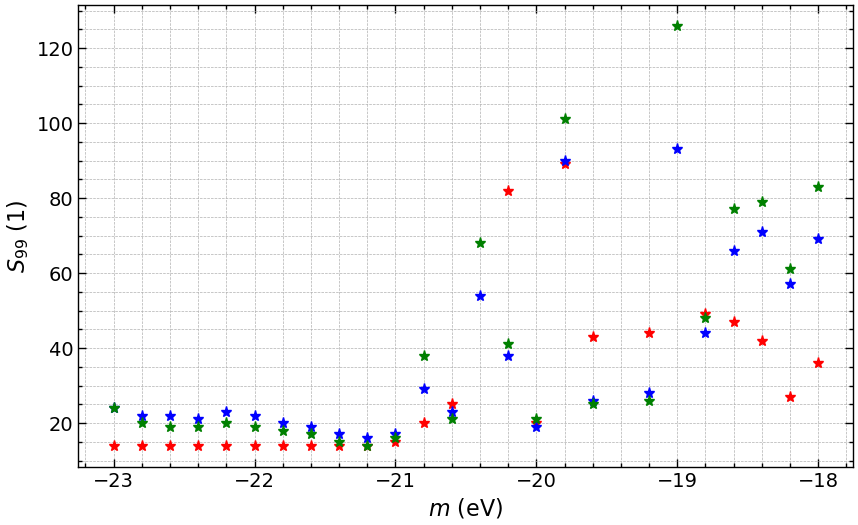

In [325]:
plt.figure(figsize=(10, 6))

plt.plot(m_exp_interval, S_A_all, "*", ms = 8, color = "red")
plt.plot(m_exp_interval, S_B_all, "*", ms = 8, color = "blue")
plt.plot(m_exp_interval, S_C_all, "*", ms = 8, color = "green")

plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.xlabel(r'$m$ (eV)', fontsize=16)
plt.ylabel(r'$S_{99}$ (1)', fontsize=16)

# Set tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Customize the legend for better clarity
plt.legend(loc='upper left', fontsize=11.5)

plt.show()

# 9 

In [13]:
best_model_r5_A = load_model("store/files/binary_classifier_spin0L_only/best_model_r5_A.keras")

In [27]:
import pickle 
# Load the scalar
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_A.pkl', 'rb') as f:
    scalar_s0l_A = pickle.load(f)

In [29]:
m_interval_list_A = [1.0000000000000327e-22,
 1.2589254117942125e-22,
 1.5848931924611758e-22,
 1.9952623149689644e-22,
 2.511886431509695e-22,
 3.1622776601685345e-22,
 3.981071705535181e-22,
 5.011872336273002e-22,
 6.309573444802304e-22,
 7.943282347243308e-22]

In [31]:
m_interval_A = np.array(m_interval_list_A) * u.eV

In [33]:
loss_s0l_A_m_all     = []
accuracy_s0l_A_m_all = []
S_A_all              = []

for m_i in tqdm(m_interval_A):

    print("----")
    print(m_i)
    
    loss_s0l_m     = []
    accuracy_s0l_m = []
    
    # masses are randomly selected from the interval mmin to mmax
    j = 0
    while j <= 150:
        
        print(j)
        
        res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [m_i, m_i], snr = j, spin = "s0l", noise_model = "white", nuis_control = 0)
        res_example_normalized = scalar_s0l_A.transform(res_example)
    
        if j == 0:
            y_example = np.zeros(len(res_example)).reshape(-1,1)
        else:
            y_example = np.ones(len(res_example)).reshape(-1,1)
    
        loss, accuracy = best_model_r5_A.evaluate(res_example_normalized, y_example)
    
        loss_s0l_m.append(loss)
        accuracy_s0l_m.append(accuracy)

        if j == 150 and accuracy < 0.99:
            S_A_all.append(None)
        
        if accuracy >= 0.99 and j != 0:
            S_A_all.append(j)
            print("S_crit = ", S_A_all[-1])
            j=150
        
        j+=1

    loss_s0l_A_m_all.append(loss_s0l_m)
    accuracy_s0l_A_m_all.append(accuracy_s0l_m)

  0%|          | 0/10 [00:00<?, ?it/s]

----
1.0000000000000327e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9991 - loss: 0.0037
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0013 - loss: 31.1147
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0059 - loss: 30.8668
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0106 - loss: 28.1227
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0378 - loss: 24.4433
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0804 - loss: 21.3254
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1542 - loss: 16.8532
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3105 - loss: 11.0685
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5097 - loss: 6.8828
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6789 - loss: 3.5259
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7718 - loss: 2.0279
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8707 - loss: 0.9281
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc

 10%|█         | 1/10 [01:32<13:55, 92.87s/it]

S_crit =  14
----
1.2589254117942125e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.2563e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0039 - loss: 32.3814
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0028 - loss: 30.2914
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0042 - loss: 28.5576
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0328 - loss: 25.4931
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0905 - loss: 21.1108
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1808 - loss: 15.9098
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3121 - loss: 10.7046
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4985 - loss: 7.1881
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6620 - loss: 3.8272
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7519 - loss: 2.0751
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8830 - loss: 1.0123
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1

 20%|██        | 2/10 [03:00<11:57, 89.73s/it]

S_crit =  14
----
1.5848931924611758e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9937 - loss: 0.0165
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0012 - loss: 31.7625
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0027 - loss: 30.8775
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0220 - loss: 28.4706
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0380 - loss: 25.2077
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0668 - loss: 21.1717
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1874 - loss: 15.7221
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2870 - loss: 12.3746
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4970 - loss: 6.6284
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6893 - loss: 3.6923
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7840 - loss: 2.0908
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8939 - loss: 0.7854
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23

 30%|███       | 3/10 [04:29<10:26, 89.56s/it]

S_crit =  14
----
1.9952623149689644e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9979 - loss: 0.0033
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0021 - loss: 31.9513
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0030 - loss: 30.9534
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0077 - loss: 28.9082
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0371 - loss: 24.1900
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0655 - loss: 21.3469
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1972 - loss: 15.8206
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3102 - loss: 10.9093
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4944 - loss: 6.5976
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6823 - loss: 3.3437
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7843 - loss: 2.0120
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8722 - loss: 1.0466
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14

 40%|████      | 4/10 [05:52<08:41, 86.91s/it]

S_crit =  14
----
2.511886431509695e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.9751e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 30.9555
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0064 - loss: 29.6959
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0174 - loss: 28.1350
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0340 - loss: 24.2721
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1023 - loss: 19.4012
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1647 - loss: 16.4617
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3470 - loss: 10.3875
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4938 - loss: 7.4936
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7129 - loss: 3.3397
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8275 - loss: 1.6938
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9192 - loss: 0.6659
12
32/32 ━━━━━━━━━━━━━━━━━━━

 50%|█████     | 5/10 [07:13<07:02, 84.59s/it]

S_crit =  14
----
3.1622776601685345e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9963 - loss: 0.0040
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0019 - loss: 31.2550
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0046 - loss: 30.1107
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0119 - loss: 27.6813
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0426 - loss: 25.1595
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0863 - loss: 20.1394
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1549 - loss: 16.2679
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3139 - loss: 11.6980
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4706 - loss: 7.7083
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6351 - loss: 4.0232
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8012 - loss: 1.7240
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9259 - loss: 0.5581
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12

 60%|██████    | 6/10 [08:37<05:38, 84.56s/it]

S_crit =  14
----
3.981071705535181e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9982 - loss: 0.0031
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0019 - loss: 31.1297
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0022 - loss: 29.4871
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0246 - loss: 27.5566
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0303 - loss: 25.4288
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1027 - loss: 20.3976
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1858 - loss: 15.8444
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3404 - loss: 11.2249
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4980 - loss: 6.3977
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6830 - loss: 3.4713
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8266 - loss: 1.4959
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8968 - loss: 0.7554
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13m

 70%|███████   | 7/10 [09:58<04:10, 83.49s/it]

S_crit =  14
----
5.011872336273002e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9997 - loss: 6.7676e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 31.6098
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0024 - loss: 30.2729
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0084 - loss: 27.6195
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0393 - loss: 24.4144
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0832 - loss: 20.9849
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1661 - loss: 15.5291
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3111 - loss: 11.3479
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5194 - loss: 6.7415
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6628 - loss: 3.8079
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8260 - loss: 1.4850
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9038 - loss: 0.9013
12
32/32 ━━━━━━━━━━━━━━━━━━━

 80%|████████  | 8/10 [11:18<02:44, 82.18s/it]

S_crit =  14
----
6.309573444802304e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9997 - loss: 5.5263e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0029 - loss: 31.1773
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0095 - loss: 31.1054
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0094 - loss: 28.1435
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0328 - loss: 25.2044
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0802 - loss: 20.5435
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1504 - loss: 16.6150
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3098 - loss: 11.0441
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4906 - loss: 6.9099
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6857 - loss: 3.1902
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8279 - loss: 1.6997
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9058 - loss: 0.6053
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

 90%|█████████ | 9/10 [12:38<01:21, 81.49s/it]

S_crit =  14
----
7.943282347243308e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9958 - loss: 0.0474
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 6.1713e-04 - loss: 32.1439
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0033 - loss: 30.1718
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0085 - loss: 28.9353
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0308 - loss: 25.5580
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0924 - loss: 21.2600
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1778 - loss: 16.1500
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2855 - loss: 12.3682
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4715 - loss: 7.3674
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6831 - loss: 3.7044
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8144 - loss: 1.7277
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8991 - loss: 0.8899
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

100%|██████████| 10/10 [13:58<00:00, 83.90s/it]

S_crit =  14


In [59]:
directory_S_m_accuracy_A = {'S_A_all': S_A_all, 'm_interval_A': m_interval_A, 'accuracy_s0l_A_m_all': accuracy_s0l_A_m_all}

# Save the dictionary as a binary file
with open('store/files/binary_classifier_spin0L_only/directory_S_m_accuracy_A_sub_1.pkl', "wb") as file:
    pickle.dump(directory_S_m_accuracy_A, file)

print("Dictionary saved successfully!")

Dictionary saved successfully!


In [20]:
import pickle

In [22]:
best_model_r5_B = load_model("store/files/binary_classifier_spin0L_only/best_model_r5_B.keras")

In [24]:
with open('store/files/binary_classifier_spin0L_only/scalar_s0l_B.pkl', 'rb') as f:
    scalar_s0l_B = pickle.load(f)

In [26]:
m_interval_list_B = [1.0000000000000327e-22,
 1.2589254117942125e-22,
 1.5848931924611758e-22,
 1.9952623149689644e-22,
 2.511886431509695e-22,
 3.1622776601685345e-22,
 3.981071705535181e-22,
 5.011872336273002e-22,
 6.309573444802304e-22,
 7.943282347243308e-22]

In [28]:
m_interval_B = np.array(m_interval_list_B) * u.eV

In [30]:
loss_s0l_B_m_all     = []
accuracy_s0l_B_m_all = []
S_B_all              = []

for m_i in tqdm(m_interval_B):

    print("----")
    print(m_i)
    
    loss_s0l_m     = []
    accuracy_s0l_m = []
    
    # masses are randomly selected from the interval mmin to mmax
    j = 0
    while j <= 150:
        
        print(j)
        
        res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [m_i, m_i], snr = j, spin = "s0l", noise_model = "white", nuis_control = 1)
        res_example_normalized = scalar_s0l_B.transform(res_example)
    
        if j == 0:
            y_example = np.zeros(len(res_example)).reshape(-1,1)
        else:
            y_example = np.ones(len(res_example)).reshape(-1,1)
    
        loss, accuracy = best_model_r5_B.evaluate(res_example_normalized, y_example)
    
        loss_s0l_m.append(loss)
        accuracy_s0l_m.append(accuracy)

        if j == 150 and accuracy < 0.99:
            S_B_all.append(None)
        
        if accuracy >= 0.99 and j != 0:
            S_B_all.append(j)
            print("S_crit = ", S_B_all[-1])
            j=150
        
        j+=1

    loss_s0l_B_m_all.append(loss_s0l_m)
    accuracy_s0l_B_m_all.append(accuracy_s0l_m)

  0%|          | 0/10 [00:00<?, ?it/s]

----
1.0000000000000327e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9633 - loss: 0.1196
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0476 - loss: 7.1426
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0520 - loss: 7.2490
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0508 - loss: 6.9481
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0638 - loss: 6.0405
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1323 - loss: 5.4160
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1043 - loss: 5.4049
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1836 - loss: 4.3622
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2176 - loss: 3.9124
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2949 - loss: 2.9809
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3893 - loss: 2.3754
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4586 - loss: 2.0094
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 

 10%|█         | 1/10 [01:28<13:12, 88.04s/it]

S_crit =  21
----
1.2589254117942125e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9647 - loss: 0.1056
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0477 - loss: 7.0625
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0525 - loss: 6.9905
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0679 - loss: 6.6920
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0637 - loss: 6.2313
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0916 - loss: 5.8266
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1277 - loss: 5.0542
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1691 - loss: 4.5031
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2667 - loss: 3.5169
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3104 - loss: 3.0445
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3988 - loss: 2.2999
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4898 - loss: 1.8040
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

 20%|██        | 2/10 [03:08<12:44, 95.51s/it]

S_crit =  20
----
1.5848931924611758e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9601 - loss: 0.1208
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0456 - loss: 7.2916
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0447 - loss: 6.7852
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0601 - loss: 6.6622
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0977 - loss: 6.1765
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1155 - loss: 5.6285
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1213 - loss: 5.0115
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1916 - loss: 4.1250
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2501 - loss: 3.6394
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3509 - loss: 2.8405
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4436 - loss: 2.1116
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4870 - loss: 1.7801
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 30%|███       | 3/10 [04:29<10:22, 88.89s/it]

S_crit =  20
----
1.9952623149689644e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9435 - loss: 0.1554
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0418 - loss: 7.1737
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0570 - loss: 7.1440
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0581 - loss: 7.0325
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0645 - loss: 6.3652
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1024 - loss: 5.7163
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1815 - loss: 4.6776
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2083 - loss: 4.2060
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2754 - loss: 3.5194
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3104 - loss: 2.8857
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4174 - loss: 2.4708
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5071 - loss: 1.7167
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

 40%|████      | 4/10 [05:46<08:25, 84.22s/it]

S_crit =  19
----
2.511886431509695e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9624 - loss: 0.1077
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0266 - loss: 7.5431
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0538 - loss: 6.9972
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0520 - loss: 6.6804
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0712 - loss: 6.1910
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1024 - loss: 5.2994
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1205 - loss: 4.6986
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1841 - loss: 4.1948
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2596 - loss: 3.6612
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3593 - loss: 2.8362
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4915 - loss: 2.1410
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5375 - loss: 1.5220
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

 50%|█████     | 5/10 [07:10<06:59, 83.89s/it]

S_crit =  20
----
3.1622776601685345e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9646 - loss: 0.1131
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0454 - loss: 7.2840
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0624 - loss: 6.6610
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0652 - loss: 6.3589
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0656 - loss: 6.2193
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1037 - loss: 5.5022
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1579 - loss: 4.6685
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2518 - loss: 3.8744
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3088 - loss: 3.1420
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3995 - loss: 2.5763
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4977 - loss: 1.8164
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6237 - loss: 1.2501
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

 60%|██████    | 6/10 [08:23<05:21, 80.36s/it]

S_crit =  18
----
3.981071705535181e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9672 - loss: 0.0885
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0361 - loss: 7.3418
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0559 - loss: 6.9615
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0708 - loss: 6.4817
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0886 - loss: 6.1699
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1328 - loss: 5.2710
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1881 - loss: 4.2836
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2424 - loss: 3.7915
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3124 - loss: 3.2779
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4715 - loss: 2.1059
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5835 - loss: 1.5039
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6920 - loss: 1.0586
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

 70%|███████   | 7/10 [09:33<03:50, 76.91s/it]

S_crit =  17
----
5.011872336273002e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9491 - loss: 0.1213
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0645 - loss: 7.2082
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0452 - loss: 7.1781
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0653 - loss: 6.5561
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0819 - loss: 5.9842
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1121 - loss: 5.6756
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1699 - loss: 4.7460
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2817 - loss: 3.8803
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3391 - loss: 3.2239
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5133 - loss: 2.2003
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6090 - loss: 1.5741
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7663 - loss: 0.8670
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

 80%|████████  | 8/10 [10:46<02:31, 75.59s/it]

S_crit =  17
----
6.309573444802304e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9642 - loss: 0.0915
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0423 - loss: 7.4787
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0495 - loss: 6.8823
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0796 - loss: 6.6337
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0923 - loss: 5.8638
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1408 - loss: 5.2594
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2103 - loss: 4.5468
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2944 - loss: 3.6187
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3934 - loss: 2.6616
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5315 - loss: 2.1066
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6882 - loss: 1.3123
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7835 - loss: 0.8096
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

 90%|█████████ | 9/10 [11:52<01:12, 72.54s/it]

S_crit =  16
----
7.943282347243308e-22 eV
0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9590 - loss: 0.1253
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0343 - loss: 7.1960
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0305 - loss: 7.5600
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0609 - loss: 6.8518
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0918 - loss: 6.2855
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1396 - loss: 5.3232
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1972 - loss: 4.6234
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2877 - loss: 3.6348
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4023 - loss: 2.8823
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5268 - loss: 2.3685
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6676 - loss: 1.4485
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7947 - loss: 0.8294
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

100%|██████████| 10/10 [12:56<00:00, 77.68s/it]

S_crit =  16


In [32]:
directory_S_m_accuracy_B = {'S_B_all': S_B_all, 'm_interval_B': m_interval_B, 'accuracy_s0l_B_m_all': accuracy_s0l_B_m_all}

# Save the dictionary as a binary file
with open('store/files/binary_classifier_spin0L_only/directory_S_m_accuracy_B_sub_1.pkl', "wb") as file:
    pickle.dump(directory_S_m_accuracy_B, file)

print("Dictionary saved successfully!")

Dictionary saved successfully!


In [36]:
accuracy_s0l_B_m_all

[[0.9649999737739563,
  0.05700000002980232,
  0.061000000685453415,
  0.05900000035762787,
  0.06499999761581421,
  0.11100000143051147,
  0.11800000071525574,
  0.18000000715255737,
  0.23999999463558197,
  0.2980000078678131,
  0.39399999380111694,
  0.46299999952316284,
  0.5619999766349792,
  0.6710000038146973,
  0.777999997138977,
  0.8379999995231628,
  0.8690000176429749,
  0.9210000038146973,
  0.9580000042915344,
  0.9660000205039978,
  0.9819999933242798,
  0.996999979019165],
 [0.9679999947547913,
  0.0430000014603138,
  0.04800000041723251,
  0.0689999982714653,
  0.07900000363588333,
  0.09700000286102295,
  0.14000000059604645,
  0.17299999296665192,
  0.26600000262260437,
  0.3070000112056732,
  0.40400001406669617,
  0.48399999737739563,
  0.6100000143051147,
  0.699999988079071,
  0.7710000276565552,
  0.8560000061988831,
  0.8949999809265137,
  0.9390000104904175,
  0.9700000286102295,
  0.9739999771118164,
  0.9909999966621399],
 [0.9599999785423279,
  0.0469999983